# Анализ данных по заболевшим COVID-19
*Дата выполнения работы: 05/05/2020*

Проблемой короновируса COVID-19 заняты многие ученые по всему миру.
В этой работе были использованы ежедневно обновляемые данные из [репозитория](https://github.com/datasets/covid-19), а конкретно [time-series-19-covid-combined.csv](https://github.com/datasets/covid-19/blob/master/data/time-series-19-covid-combined.csv).

Цель состояла в изучении имеющихся данных и поиске некоторых закономерностей. 


In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sma
import statsmodels.formula.api as smfa
import statsmodels.tsa.stattools as smstt
%matplotlib inline

pd.options.display.float_format = '{:.2f}'.format

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 15)

In [ ]:
df = pd.read_csv('/content/drive/My Drive/time-series-19-covid-combined.csv')
df.head()

,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths
0,2020-01-22,Afghanistan,NaN,33.00,65.00,0.00,0.00,0.00
1,2020-01-23,Afghanistan,NaN,33.00,65.00,0.00,0.00,0.00
2,2020-01-24,Afghanistan,NaN,33.00,65.00,0.00,0.00,0.00
3,2020-01-25,Afghanistan,NaN,33.00,65.00,0.00,0.00,0.00
4,2020-01-26,Afghanistan,NaN,33.00,65.00,0.00,0.00,0.00


## 1. Exploratory data analysis

#### 1.1 Определите границы исследуемого периода, количество заболевших, погибших, выздоровивших. Отобразите на карте распространение болезни.

In [ ]:
last_day = max(df['Date'])

Confirmed = df['Confirmed'].loc[df['Date'] == last_day].sum()
Recovered = df['Recovered'].loc[df['Date'] == last_day].sum()
Deaths = df['Deaths'].loc[df['Date'] == last_day].sum()

print('Исследуемый период: с ' + min(df['Date']) + ' по ' + last_day +
      '\n\nНа ' + last_day + ': '
'\nЗаболели:: ' + str(Confirmed) +
'\nВыздоровели: ' + str(Recovered) +
'\nПогибли: ' + str(Deaths))


Исследуемый период: с 2020-01-22 по 2020-05-01

На 2020-05-01: 
Заболели:: 3343777.0
Выздоровели: 1053327.0
Погибли: 238650.0


In [ ]:
df_mp = df[df['Date'] == last_day]
df_mp.head()

,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths
100,2020-05-01,Afghanistan,NaN,33.00,65.00,2335.00,310.00,68.00
201,2020-05-01,Albania,NaN,41.15,20.17,782.00,488.00,31.00
302,2020-05-01,Algeria,NaN,28.03,1.66,4154.00,1821.00,453.00
403,2020-05-01,Andorra,NaN,42.51,1.52,745.00,468.00,43.00
504,2020-05-01,Angola,NaN,-11.20,17.87,30.00,11.00,2.00


In [ ]:
import plotly.express as px
px.set_mapbox_access_token('pk.eyJ1IjoiZ3Rzb3kiLCJhIjoiY2s5dDM5b3RwMDBhdjNlbm9wOWIxYnVyeSJ9.0Yk02XDJHrb--az9Bs2n-w')

fig = px.scatter_mapbox(df_mp, lat="Lat", lon="Long",   text='Country/Region',  color="Confirmed", 
                  color_continuous_scale=px.colors.cyclical.IceFire, zoom=1)
fig.show()

**Вывод**: Вирус распространился почти по всему миру, заболевших насчитывается больше 3 миллионов, треть из которых выздоровела.

#### 1.2 Определите количество стран, которые подтвердили случаи заражения. Визуализируйте рост количества стран, подтвердивших случаи заражения по дням (или неделям). 

  *Примечание. В анализе временных рядов иногда необходимо изменить частоту дискретизации (Resampling). Такая операция может понадобится, когда имеющихся данных недостаточно или их, наоборот, слишком много. Может не устраивать имеющаяся частота или просто хочется посмотреть на данные с более общего ракурса.*

  *Различают два вида изменения частоты: повышение (Upsampling) и понижение (Downsampling). При повышении временной ряд пересчитывается с низкой частоы на более высокую частоту (например от годовой до месячной частоты). В таком случае процесс включает в себя заполнение или интерполяцию появившихся пропусков в данных. При понижении временной ряд передискретизируется с высокой частоты на низкую (наример с еженедельной на месячную частоту). Это включает в себя агрегацию существующих данных.*

In [ ]:
number_confirmed_countries = len(df[df['Confirmed'] > 0].groupby('Country/Region'))

print('Число подтвердивших стран: ' + str(number_confirmed_countries))

Число подтвердивших стран: 187


Фисксирую рост количества стран, подтвердивших случаи заражания. Отображаю на графике рост по дням, затем по неделям (Downsampling).

In [ ]:
df_tranformed = df.groupby(['Date', 'Country/Region'], as_index=False)['Confirmed'].sum()
df_tranformed['is_confirmed'] = np.where(df_tranformed['Confirmed'] > 0, 1, 0)
df_tranformed = df_tranformed.groupby('Date', as_index=False)['is_confirmed'].sum().sort_values(by = "Date", ascending = False)
print(df_tranformed)

           Date  is_confirmed
100  2020-05-01           187
99   2020-04-30           187
98   2020-04-29           185
97   2020-04-28           185
96   2020-04-27           185
..          ...           ...
4    2020-01-26            13
3    2020-01-25            11
2    2020-01-24             9
1    2020-01-23             8
0    2020-01-22             6

[101 rows x 2 columns]


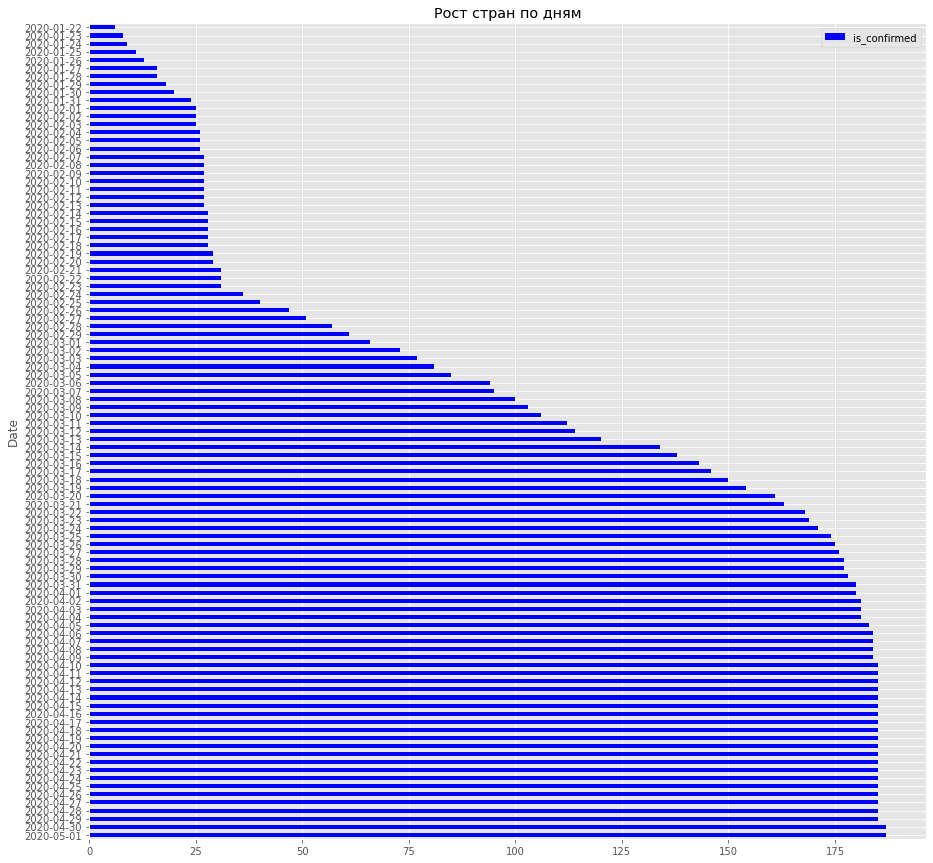

In [ ]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 15)
df_tranformed.plot(kind ="barh", x = 'Date', y = 'is_confirmed', colormap='winter', title = 'Рост стран по дням')

In [ ]:
df_tranformed_ds = df_tranformed.sort_values(by = "Date", ascending = True)
df_tranformed_ds['start_week'] = pd.date_range('22/01/2020',
                                    periods=101,
                                    freq='D')
df_tranformed_ds = df_tranformed_ds.resample('W', on='start_week')['is_confirmed'].max().sort_values(ascending=False)
df_tranformed_ds

start_week
2020-05-03    187
2020-04-26    185
2020-04-19    185
2020-04-12    185
2020-04-05    183
2020-03-29    177
2020-03-22    168
2020-03-15    138
2020-03-08    100
2020-03-01     66
2020-02-23     31
2020-02-16     28
2020-02-09     27
2020-02-02     25
2020-01-26     13
Name: is_confirmed, dtype: int64

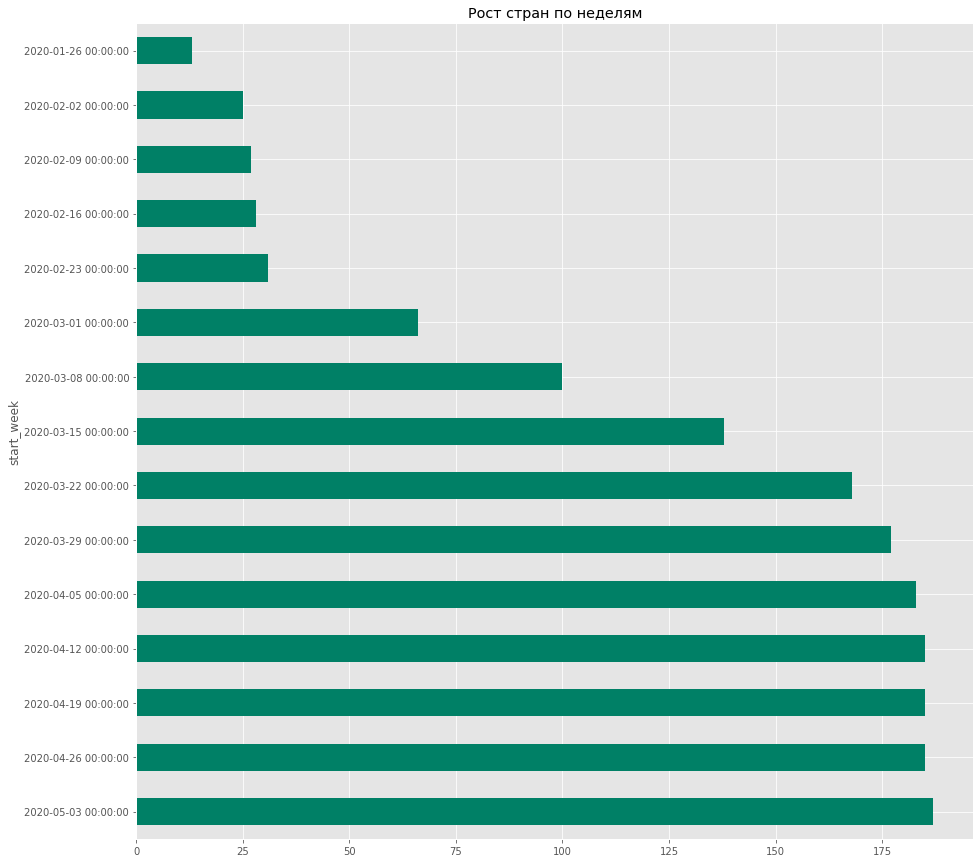

In [ ]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 15)
df_tranformed_ds.plot(kind ="barh", y = 'is_confirmed', colormap='summer', title = 'Рост стран по неделям')

**Вывод**: на графиках видно, что с середины февраля до середины марта вирус распространялся стремительно по миру. Начиная примерно с 29 марта случаи болезни были зафексированы почти во всех странах из датасета.

#### 1.3 Визуализируйте мировые тренды по числу заболевших | погибших | выздоровивших. Постройте графики, которые отражают летальность от вируса в разных странах или на разных континентах. 

In [ ]:
df_world_trends = df.groupby(['Date'], as_index=False)['Confirmed', 'Recovered', 'Deaths'].sum()
df_world_trends.head()

,Date,Confirmed,Recovered,Deaths
0,2020-01-22,555.00,28.00,17.00
1,2020-01-23,654.00,30.00,18.00
2,2020-01-24,941.00,36.00,26.00
3,2020-01-25,1434.00,39.00,42.00
4,2020-01-26,2118.00,52.00,56.00


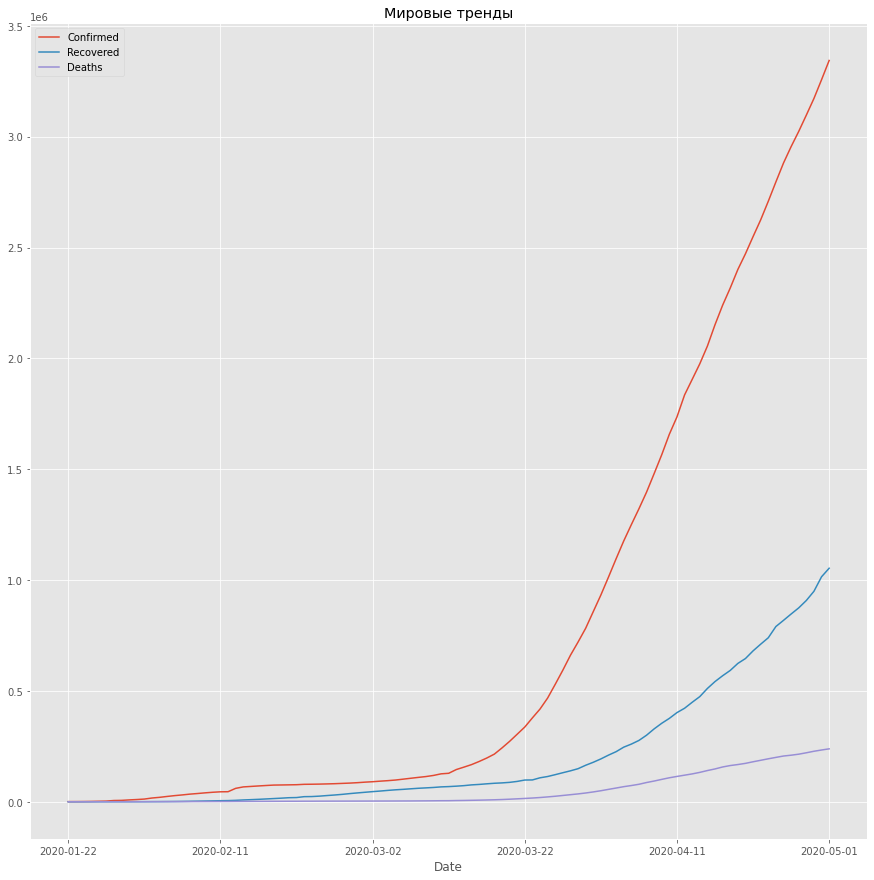

In [ ]:
df_world_trends.plot(kind = "line", x = 'Date', y = ['Confirmed', 'Recovered', 'Deaths'], title = 'Мировые тренды')

График летальности для 5 стран. Для сравнения были выбраны Италия, Испания, США как, известные по новостям, большие очаги распространения вируса. Китай, как изначальный эпицентр. Швеция, как страна борющаяся с вирусом без применения активных карантинных мер.


In [ ]:
df_cfr = df.groupby(['Date', 'Country/Region'], as_index=False)['Confirmed', 'Recovered', 'Deaths'].sum()
df_cfr['CFR'] = df_cfr['Deaths']/df_cfr['Confirmed']
df_cfr

,Date,Country/Region,Confirmed,Recovered,Deaths,CFR
0,2020-01-22,Afghanistan,0.00,0.00,0.00,nan
1,2020-01-22,Albania,0.00,0.00,0.00,nan
2,2020-01-22,Algeria,0.00,0.00,0.00,nan
3,2020-01-22,Andorra,0.00,0.00,0.00,nan
4,2020-01-22,Angola,0.00,0.00,0.00,nan
...,...,...,...,...,...,...
18882,2020-05-01,West Bank and Gaza,353.00,76.00,2.00,0.01
18883,2020-05-01,Western Sahara,6.00,5.00,0.00,0.00
18884,2020-05-01,Yemen,7.00,1.00,2.00,0.29
18885,2020-05-01,Zambia,109.00,74.00,3.00,0.03


In [ ]:
d = {'Date': df.groupby('Date').sum().index,
                         'China': list(df_cfr[df_cfr['Country/Region'] == 'China']['CFR']),
                         'Sweden': list(df_cfr[df_cfr['Country/Region'] == 'Sweden']['CFR']),
                         'US': list(df_cfr[df_cfr['Country/Region'] == 'US']['CFR']),
                         'Italy': list(df_cfr[df_cfr['Country/Region'] == 'Italy']['CFR']),                                                                           
                         'Spain': list(df_cfr[df_cfr['Country/Region'] == 'Spain']['CFR'])}
df_cfr_5 = pd.DataFrame(data=d)
df_cfr_5

,Date,China,Sweden,US,Italy,Spain
0,2020-01-22,0.03,nan,0.00,nan,nan
1,2020-01-23,0.03,nan,0.00,nan,nan
2,2020-01-24,0.03,nan,0.00,nan,nan
3,2020-01-25,0.03,nan,0.00,nan,nan
4,2020-01-26,0.03,nan,0.00,nan,nan
...,...,...,...,...,...,...
96,2020-04-27,0.06,0.12,0.06,0.14,0.11
97,2020-04-28,0.06,0.12,0.06,0.14,0.11
98,2020-04-29,0.06,0.12,0.06,0.14,0.11
99,2020-04-30,0.06,0.12,0.06,0.14,0.11


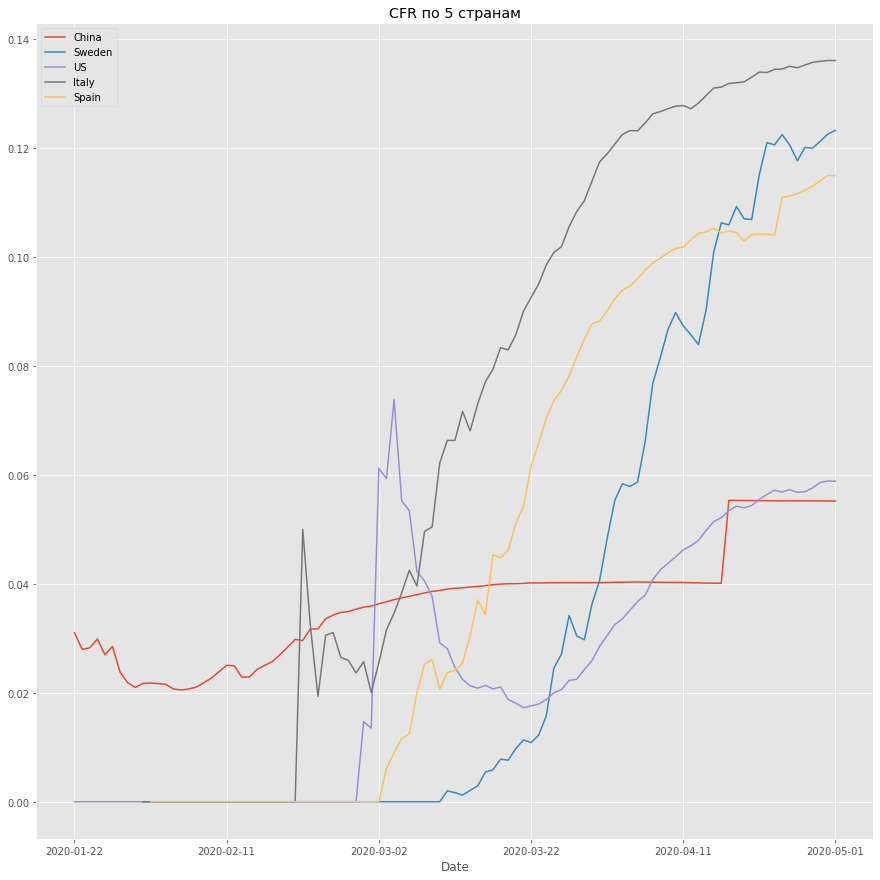

In [ ]:
df_cfr_5.plot(kind = "line", x = 'Date', y = ['China', 'Sweden', 'US', 'Italy', 'Spain'], title = 'CFR по 5 странам')

На картинке видно, что у Италии и Испании наблюдаются явные сходства, что может являться следствием географической близости.

Определенные сходства есть с США, а именно резкий рост летальности в начале эпидемии. Это говорит об общей неготовности стран к началу распространения короновируса и малочи числе зарегестрированных случаев. Однако скачок сменяется спадом и опять постепенным ростом. В США у летальности относительно хорошее значение, но причина может быть чуть более позднее начало распространения.

Швеция избежала скачка летальности в начале эпидемии, и этот показатель начал расти постепенно и примерно на 20 дней позже, чем в других странах на графике. Однако, сейчас Швеция идет сразу после Италии, что не является хорошим показателем.

Ситуация в Китая визуально наиболее стабильная, поскольку пик эпидемии пришелся на месяц раньше. В то время, как остальные страны на графике столкнулись с первыми случаями короновируса, лишь начиная с середины февраля и позже.

**Вывод:** На графике мировых трендов видно, что активное распространение вируса началось примерно с середины марта. С этого момента кривые имеют экспоненциальный рост.

В разных странах заражение прохоило по разным сценариям, однако можно выделить некоторые частные патерны. Например, скачок летальности в начале распросранения, который обусловлен малым числов выявленных заражений (условно на 3 заражения приходится 1 смерть = летальность 33%). Затем падение показателя летальности и постепенный рост.

#### 1.4 Визуализируйте и сравните, как распространялась болезнь в разных странах или континентах по дням с первого зарегистрированного случая заболевания. Определите количество дней для каждой страны со дня первого зарегестрированного случая.

Группирую данные по дням и странам

In [ ]:
df_grb_date_country = df.groupby(['Date', 'Country/Region'], as_index=False)['Confirmed'].sum()
df_grb_date_country

,Date,Country/Region,Confirmed
0,2020-01-22,Afghanistan,0.00
1,2020-01-22,Albania,0.00
2,2020-01-22,Algeria,0.00
3,2020-01-22,Andorra,0.00
4,2020-01-22,Angola,0.00
...,...,...,...
18882,2020-05-01,West Bank and Gaza,353.00
18883,2020-05-01,Western Sahara,6.00
18884,2020-05-01,Yemen,7.00
18885,2020-05-01,Zambia,109.00


Выделяю 5 стран и строю графики распространения

In [ ]:
df_Italy = df_grb_date_country[(df_grb_date_country['Country/Region'] == 'Italy') & (df_grb_date_country['Confirmed'] > 0)]
df_Spain = df_grb_date_country[(df_grb_date_country['Country/Region'] == 'Spain') & (df_grb_date_country['Confirmed'] > 0)]
df_Sweden = df_grb_date_country[(df_grb_date_country['Country/Region'] == 'Sweden') & (df_grb_date_country['Confirmed'] > 0)]
df_US = df_grb_date_country[(df_grb_date_country['Country/Region'] == 'US') & (df_grb_date_country['Confirmed'] > 0)]
df_China = df_grb_date_country[(df_grb_date_country['Country/Region'] == 'China') & (df_grb_date_country['Confirmed'] > 0)]

In [ ]:
df_grb_date_country[(df_grb_date_country['Country/Region'] == 'China') & (df_grb_date_country['Confirmed'] > 0)]

,Date,Country/Region,Confirmed
36,2020-01-22,China,548.00
223,2020-01-23,China,643.00
410,2020-01-24,China,920.00
597,2020-01-25,China,1406.00
784,2020-01-26,China,2075.00
...,...,...,...
17988,2020-04-27,China,83918.00
18175,2020-04-28,China,83940.00
18362,2020-04-29,China,83944.00
18549,2020-04-30,China,83956.00


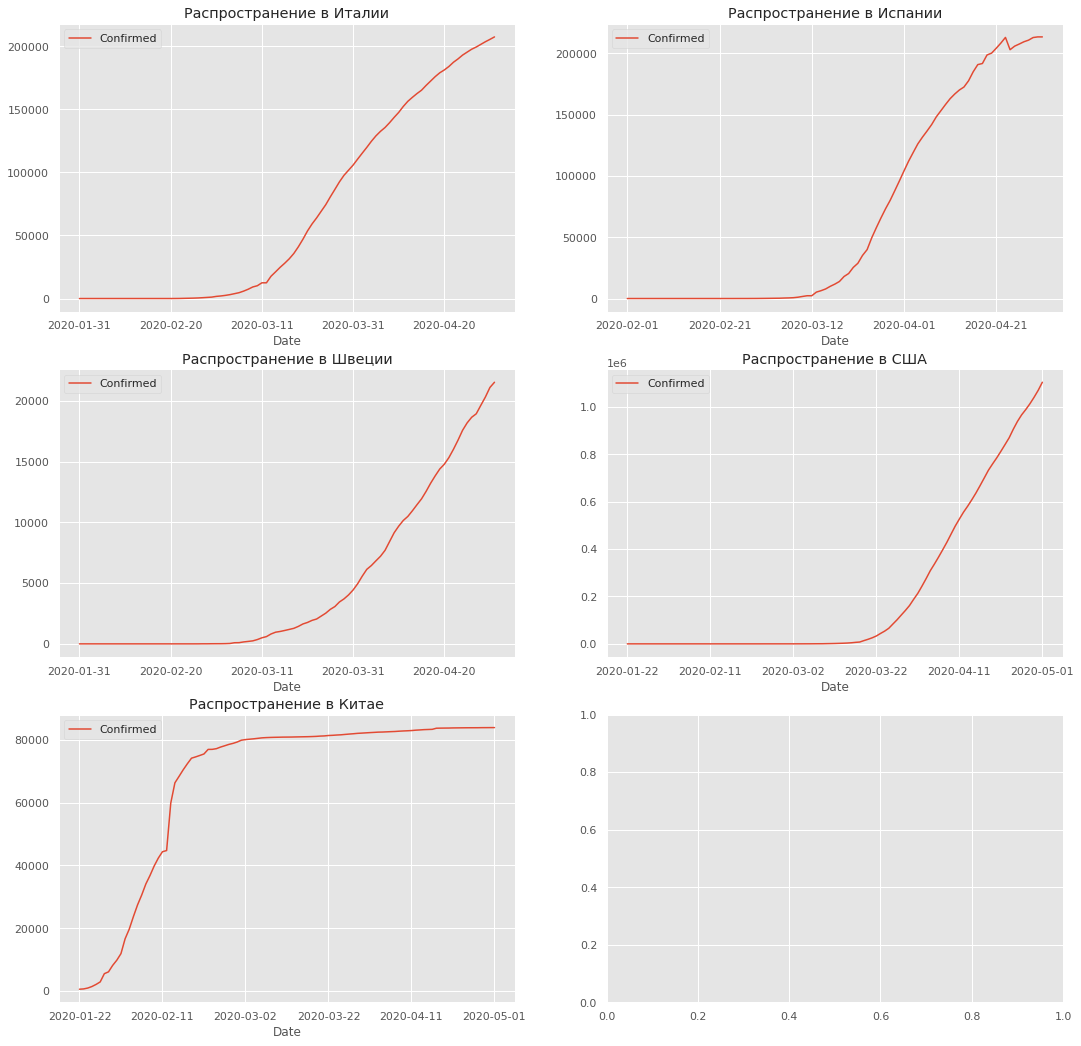

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18,18))

df_Italy.plot(kind = "line", x = 'Date', y = 'Confirmed', title = 'Распространение в Италии', ax=axes[0,0])
df_Spain.plot(kind = "line", x = 'Date', y = 'Confirmed', title = 'Распространение в Испании', ax=axes[0,1])
df_Sweden.plot(kind = "line", x = 'Date', y = 'Confirmed', title = 'Распространение в Швеции', ax=axes[1,0])
df_US.plot(kind = "line", x = 'Date', y = 'Confirmed', title = 'Распространение в США', ax=axes[1,1])
df_China.plot(kind = "line", x = 'Date', y = 'Confirmed', title = 'Распространение в Китае', ax=axes[2,0])

На графиках видно, что ситуация в Италии и Испании в целом повторяется. Как по датам, так и по числу зараженных, более выпуклой кривой роста.

В Швеции и США график более пологий, однако, в США наблюдается более резкий рост с середины марта и есть серьезная разница в количестве больных.

В Китае видно, что несмотря на сильный рост в первых дух месяцах зимы, к весне ситуация нормализовалась. Эпидемию удалось сдержать и число случаев меньше, чем в других представленных на картинках странах.

Расчитываю количество дней с момента регистрации болезни

In [ ]:
countries = list(df.groupby('Country/Region').sum().index)
df_countries_days = pd.DataFrame({'Countries': countries})
first_day = []

for c in countries:
  f_d = df_grb_date_country[(df_grb_date_country['Country/Region'] == c) & (df_grb_date_country['Confirmed'] > 0)].min()['Date']
  first_day.append(f_d)

In [ ]:

df_countries_days['First_day'] = first_day

last_day_datetime = pd.to_datetime(last_day)
difference = list(last_day_datetime - pd.to_datetime(df_countries_days['First_day']))

df_countries_days['Number_of_days_from_first_case'] = difference
df_countries_days.sort_values(by ='Number_of_days_from_first_case')

,Countries,First_day,Number_of_days_from_first_case
38,Comoros,2020-04-30,1 days
165,Tajikistan,2020-04-30,1 days
184,Yemen,2020-04-10,21 days
145,Sao Tome and Principe,2020-04-06,25 days
183,Western Sahara,2020-04-05,26 days
...,...,...,...
164,Taiwan*,2020-01-22,100 days
91,"Korea, South",2020-01-22,100 days
173,US,2020-01-22,100 days
87,Japan,2020-01-22,100 days


**Вывод:** В большинстве стран вирус обнаружили ранее месяца назад. В анализируемых странах болезнь распространялась стремительно и пока ситуация визуально не стабилизирована. Однако, причина в том, что прошло не так много времени с начала эпидении (Например, в Китае число зараженных с начала марта держится относительно одинаковое)

#### 1.5 Визуализируйте и оцените как развивалась ситуация в России по сравнению с остальными миром.

К данным о мировых трендах, полученных ранее, добавляю информацию о летальности. После собираю статистику и по России.


In [ ]:
df_world_trends['CFR'] = df_world_trends['Deaths']/df_world_trends['Confirmed']
df_world_trends

,Date,Confirmed,Recovered,Deaths,CFR
0,2020-01-22,555.00,28.00,17.00,0.03
1,2020-01-23,654.00,30.00,18.00,0.03
2,2020-01-24,941.00,36.00,26.00,0.03
3,2020-01-25,1434.00,39.00,42.00,0.03
4,2020-01-26,2118.00,52.00,56.00,0.03
...,...,...,...,...,...
96,2020-04-27,3023722.00,874457.00,214515.00,0.07
97,2020-04-28,3097190.00,907832.00,220830.00,0.07
98,2020-04-29,3172287.00,949315.00,227696.00,0.07
99,2020-04-30,3256853.00,1014775.00,233388.00,0.07


In [ ]:
df_Russia = df[df['Country/Region'] == 'Russia']
df_Russia['CFR'] = df_Russia['Deaths']/df_Russia['Confirmed']
df_Russia['Conf_w'] = np.array(df_Russia['Confirmed'])/np.array(df_world_trends['Confirmed'])
df_Russia['Rec_w'] = np.array(df_Russia['Recovered'])/np.array(df_world_trends['Recovered'])
df_Russia

,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths,CFR,Conf_w,Rec_w
21008,2020-01-22,Russia,NaN,60.00,90.00,0.00,0.00,0.00,nan,0.00,0.00
21009,2020-01-23,Russia,NaN,60.00,90.00,0.00,0.00,0.00,nan,0.00,0.00
21010,2020-01-24,Russia,NaN,60.00,90.00,0.00,0.00,0.00,nan,0.00,0.00
21011,2020-01-25,Russia,NaN,60.00,90.00,0.00,0.00,0.00,nan,0.00,0.00
21012,2020-01-26,Russia,NaN,60.00,90.00,0.00,0.00,0.00,nan,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...
21104,2020-04-27,Russia,NaN,60.00,90.00,87147.00,7346.00,794.00,0.01,0.03,0.01
21105,2020-04-28,Russia,NaN,60.00,90.00,93558.00,8456.00,867.00,0.01,0.03,0.01
21106,2020-04-29,Russia,NaN,60.00,90.00,99399.00,10286.00,972.00,0.01,0.03,0.01
21107,2020-04-30,Russia,NaN,60.00,90.00,106498.00,11619.00,1073.00,0.01,0.03,0.01


In [ ]:
df_Russia_ds = df_Russia
df_Russia_ds['start_week'] = pd.date_range('22/01/2020',
                                    periods=101,
                                    freq='D')
df_Russia_ds = df_Russia_ds.resample('W', on='start_week')['Confirmed', 'Recovered', 'Deaths', 'CFR'].sum()

df_world_trends_ds = df_world_trends
df_world_trends_ds['start_week'] = pd.date_range('22/01/2020',
                                    periods=101,
                                    freq='D')
df_world_trends_ds = df_world_trends_ds.resample('W', on='start_week')['Confirmed', 'Recovered', 'Deaths', 'CFR'].max()
df_world_trends_ds

,Confirmed,Recovered,Deaths,CFR
start_week,,,,
2020-01-26,2118.00,52.00,56.00,0.03
2020-02-02,16787.00,472.00,362.00,0.03
2020-02-09,40150.00,3244.00,906.00,0.02
2020-02-16,71224.00,10865.00,1770.00,0.02
2020-02-23,78958.00,23394.00,2469.00,0.03
2020-03-01,88369.00,42716.00,2996.00,0.03
2020-03-08,109821.00,60694.00,3801.00,0.03
2020-03-15,167466.00,76034.00,6472.00,0.04
2020-03-22,337018.00,97899.00,14825.00,0.04


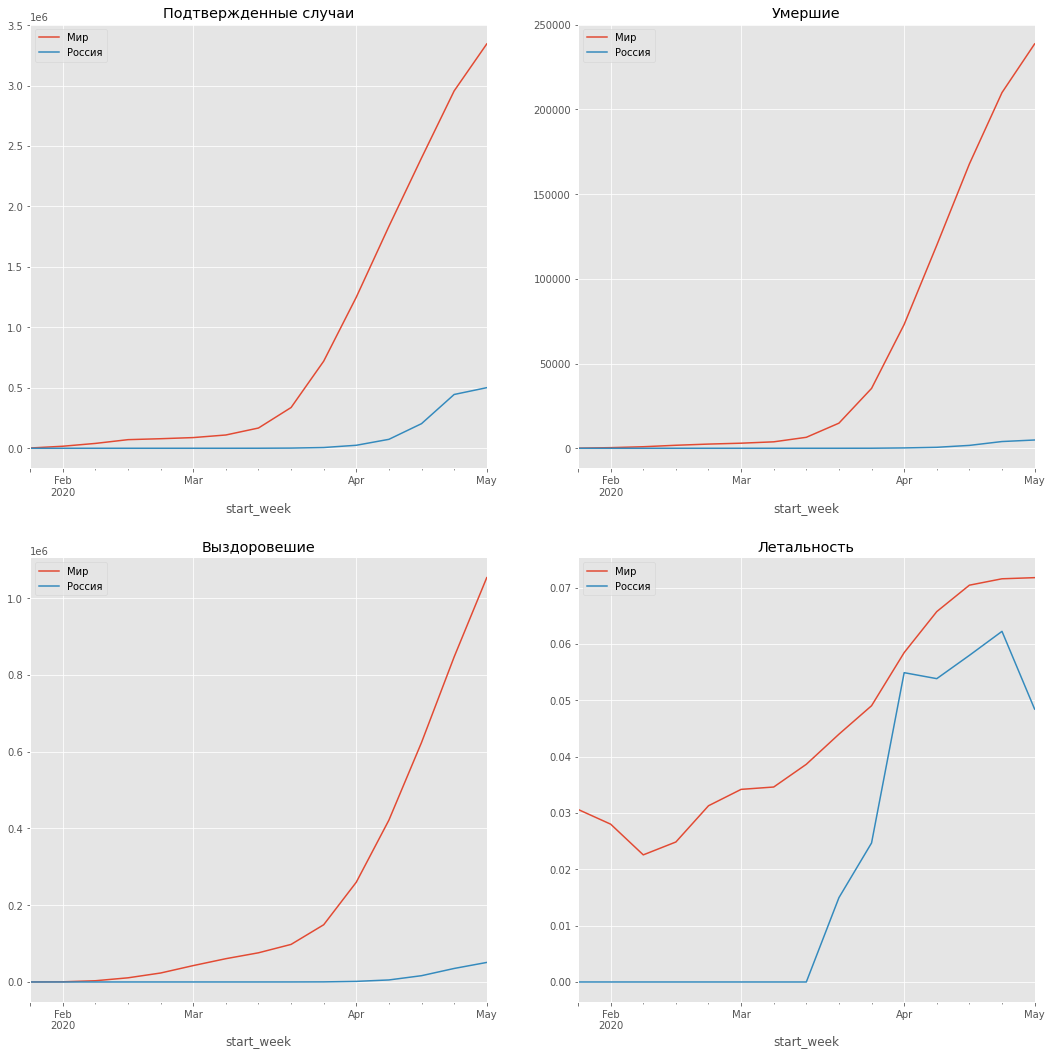

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,18))

df_world_trends_ds.plot(kind = "line",  y = 'Confirmed', label='Мир', title = 'Подтвержденные случаи', ax=axes[0,0])
df_Russia_ds.plot(kind = "line", y = 'Confirmed', label='Россия', ax=axes[0,0])

df_world_trends_ds.plot(kind = "line", y = 'Deaths', label='Мир', title = 'Умершие', ax=axes[0,1])
df_Russia_ds.plot(kind = "line", y = 'Deaths', label='Россия', ax=axes[0,1])

df_world_trends_ds.plot(kind = "line", y = 'Recovered', label='Мир', title = 'Выздоровешие', ax=axes[1,0])
df_Russia_ds.plot(kind = "line", y = 'Recovered', label='Россия', ax=axes[1,0])

df_world_trends_ds.plot(kind = "line", y = 'CFR', label='Мир', title = 'Летальность', ax=axes[1,1])
df_Russia_ds.plot(kind = "line", y = 'CFR', label='Россия', ax=axes[1,1])

**Вывод:** на графиках видно, что Россия в целом повторяет мировой тренд и все показатели увеличиваются со временем. Однако заметно, что больные в России начали появляться позже, чем в остальном мире. Летальность, и в моменты пика в апреле, не превышала общемировую, что является хорошим показателем.

#### 1.6 Определите топ-10 стран, которые лидируют по имеющимся в датасете показателям. Сравните насколько быстро развивается ситуация в этих странах, определите корреляцию.

**Лидеры по подтвержденным случаям:** Ниже видно, что ситуация в 10 странах развивалась примерно одинакого. Это подтверждают результаты корреляции - самый низкий показатель равен 0.78. Однако на графике видно, что США остается безогоорочным лидером по количеству заболевших короновирусом.
Кроме того, можно отметить, что 6 из 10 стран, находятся в Европе, при этом нет не одной азиатской страны. В том числе и Китая, где вирус был обнаружен первым. Это говорит о том, что на востоке были приняты более эффективные меры по борьбе с распространением вируса.

In [ ]:
top_confirmed = df.groupby('Country/Region', as_index = False)['Confirmed'].max().sort_values(by = "Confirmed", ascending = False)[0:10]
top_confirmed

,Country/Region,Confirmed
173,US,1103461.00
157,Spain,213435.00
85,Italy,207428.00
177,United Kingdom,177454.00
62,France,167605.00
66,Germany,164077.00
172,Turkey,122392.00
139,Russia,114431.00
81,Iran,95646.00
23,Brazil,92202.00


In [ ]:
dc = {'Date': df.groupby('Date').sum().index,
                         'US': list(df[df['Country/Region'] == 'US']['Confirmed']),
                         'Italy': list(df[df['Country/Region'] == 'Italy']['Confirmed']),
                         'Spain': list(df[df['Country/Region'] == 'Spain']['Confirmed']),
                         'United Kingdom': list(df[df['Country/Region'] == 'United Kingdom'].groupby(['Date'], as_index = False).sum()['Confirmed']),
                         'France': list(df[df['Country/Region'] == 'France'].groupby(['Date'], as_index = False).sum()['Confirmed']),
                         'Germany': list(df[df['Country/Region'] == 'Germany']['Confirmed']),
                         'Turkey': list(df[df['Country/Region'] == 'Turkey']['Confirmed']),
                         'Russia': list(df[df['Country/Region'] == 'Russia']['Confirmed']),
                         'Iran': list(df[df['Country/Region'] == 'Iran']['Confirmed']),
                          'Brazil': list(df[df['Country/Region'] == 'Brazil']['Confirmed'])
                          }
df_corr_confirmed = pd.DataFrame(data=dc)
df_corr_confirmed

,Date,US,Italy,Spain,United Kingdom,France,Germany,Turkey,Russia,Iran,Brazil
0,2020-01-22,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2020-01-23,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2020-01-24,2.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00
3,2020-01-25,2.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00
4,2020-01-26,5.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...
96,2020-04-27,988197.00,199414.00,209465.00,158348.00,165963.00,158758.00,112261.00,87147.00,91472.00,67446.00
97,2020-04-28,1012582.00,201505.00,210773.00,162350.00,169053.00,159912.00,114653.00,93558.00,92584.00,73235.00
98,2020-04-29,1039909.00,203591.00,212917.00,166441.00,166543.00,161539.00,117589.00,99399.00,93657.00,79685.00
99,2020-04-30,1069424.00,205463.00,213435.00,172481.00,167299.00,163009.00,120204.00,106498.00,94640.00,87187.00


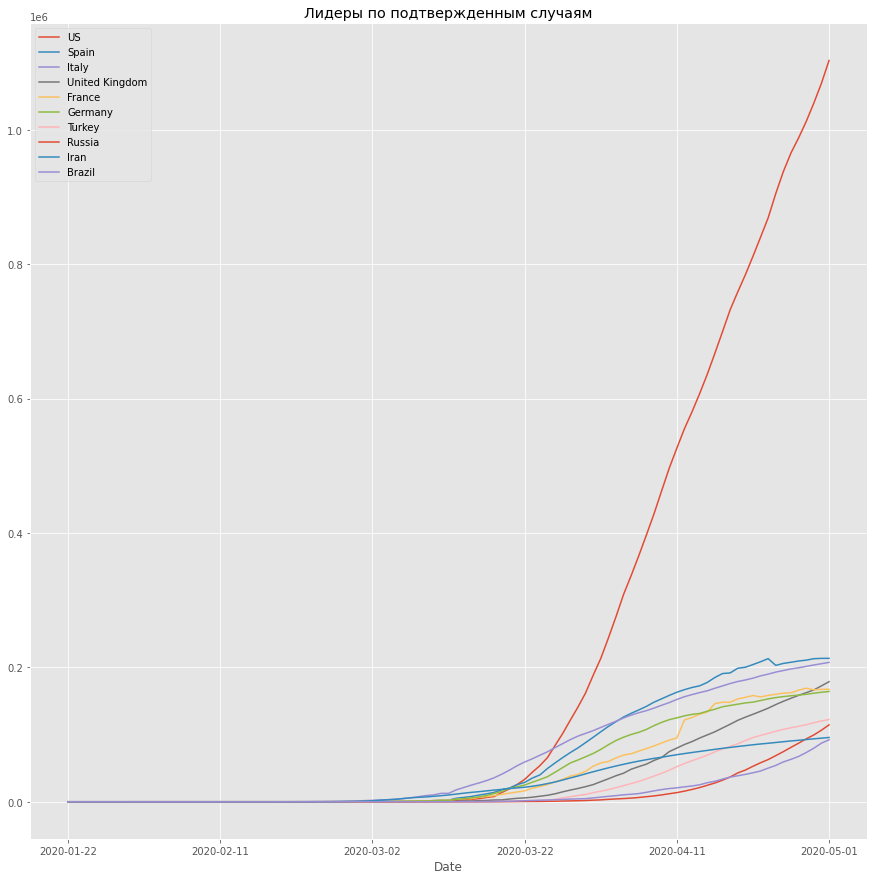

In [ ]:
df_corr_confirmed.plot(kind = "line", x = 'Date', y = ['US',
 'Spain',
 'Italy',
 'United Kingdom',
 'France',
 'Germany',
 'Turkey',
 'Russia',
 'Iran',
 'Brazil'], title = 'Лидеры по подтвержденным случаям')


In [ ]:
df_corr_confirmed.corr()

,US,Italy,Spain,United Kingdom,France,Germany,Turkey,Russia,Iran,Brazil
US,1.00,0.94,0.96,1.00,0.99,0.96,1.00,0.92,0.96,0.96
Italy,0.94,1.00,0.99,0.94,0.97,0.99,0.92,0.78,1.00,0.85
Spain,0.96,0.99,1.00,0.96,0.99,1.00,0.94,0.80,0.99,0.87
United Kingdom,1.00,0.94,0.96,1.00,0.98,0.95,1.00,0.93,0.95,0.97
France,0.99,0.97,0.99,0.98,1.00,0.99,0.98,0.86,0.98,0.92
Germany,0.96,0.99,1.00,0.95,0.99,1.00,0.94,0.80,1.00,0.87
Turkey,1.00,0.92,0.94,1.00,0.98,0.94,1.00,0.94,0.93,0.97
Russia,0.92,0.78,0.80,0.93,0.86,0.80,0.94,1.00,0.80,0.99
Iran,0.96,1.00,0.99,0.95,0.98,1.00,0.93,0.80,1.00,0.87
Brazil,0.96,0.85,0.87,0.97,0.92,0.87,0.97,0.99,0.87,1.00


**Лидеры по смертности:** Неудивительно, что 8 из 10 стран из предыдущего списка являются лидерами и по смертности. Попадание в этот топ еще двух европейских стран: Бельгии и Недерландов еще раз подтвеждает вывод, сделанный выше о низкой готовности к распространеннию вируса. К тому же важную роль сыграла территориальная близость государств.
На графике видно, что тренд у всех примерно совпадает, но страны разделились на три категории. Безоговорочным лидером по-прежнему является США. Затем почти одинаковые кривые демонстрируют Италия, Великобритания, Франция и Испания. С большим отрывом идут оставшиеся 5 стран. Корреляция аналогично подтвержает схоство.

In [ ]:
top_deaths = df.groupby('Country/Region', as_index = False)['Deaths'].max().sort_values(by = "Deaths", ascending = False)[0:10]
top_deaths

,Country/Region,Deaths
173,US,64943.00
85,Italy,28236.00
177,United Kingdom,27510.00
62,France,24594.00
157,Spain,24543.00
16,Belgium,7703.00
66,Germany,6736.00
23,Brazil,6412.00
81,Iran,6091.00
121,Netherlands,4893.00


In [ ]:
dc = {'Date': df.groupby('Date').sum().index,
                         'US': list(df[df['Country/Region'] == 'US']['Deaths']),
                         'Italy': list(df[df['Country/Region'] == 'Italy']['Deaths']),
                         'Spain': list(df[df['Country/Region'] == 'Spain']['Deaths']),
                         'United Kingdom': list(df[df['Country/Region'] == 'United Kingdom'].groupby(['Date'], as_index = False).sum()['Deaths']),
                         'France': list(df[df['Country/Region'] == 'France'].groupby(['Date'], as_index = False).sum()['Deaths']),
                         'Germany': list(df[df['Country/Region'] == 'Germany']['Deaths']),
                         'Belgium': list(df[df['Country/Region'] == 'Turkey']['Deaths']),
                         'Netherlands': list(df[df['Country/Region'] == 'Russia']['Deaths']),
                         'Iran': list(df[df['Country/Region'] == 'Iran']['Deaths']),
                          'Brazil': list(df[df['Country/Region'] == 'Brazil']['Deaths'])
                          }
df_corr_deaths = pd.DataFrame(data=dc)
df_corr_deaths

,Date,US,Italy,Spain,United Kingdom,France,Germany,Belgium,Netherlands,Iran,Brazil
0,2020-01-22,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2020-01-23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2020-01-24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,2020-01-25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,2020-01-26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...
96,2020-04-27,56259.00,26977.00,23521.00,24458.00,23327.00,6126.00,2900.00,794.00,5806.00,4603.00
97,2020-04-28,58355.00,27359.00,23822.00,25369.00,23694.00,6314.00,2992.00,867.00,5877.00,5083.00
98,2020-04-29,60967.00,27682.00,24275.00,26166.00,24121.00,6467.00,3081.00,972.00,5957.00,5513.00
99,2020-04-30,62996.00,27967.00,24543.00,26842.00,24410.00,6623.00,3174.00,1073.00,6028.00,6006.00


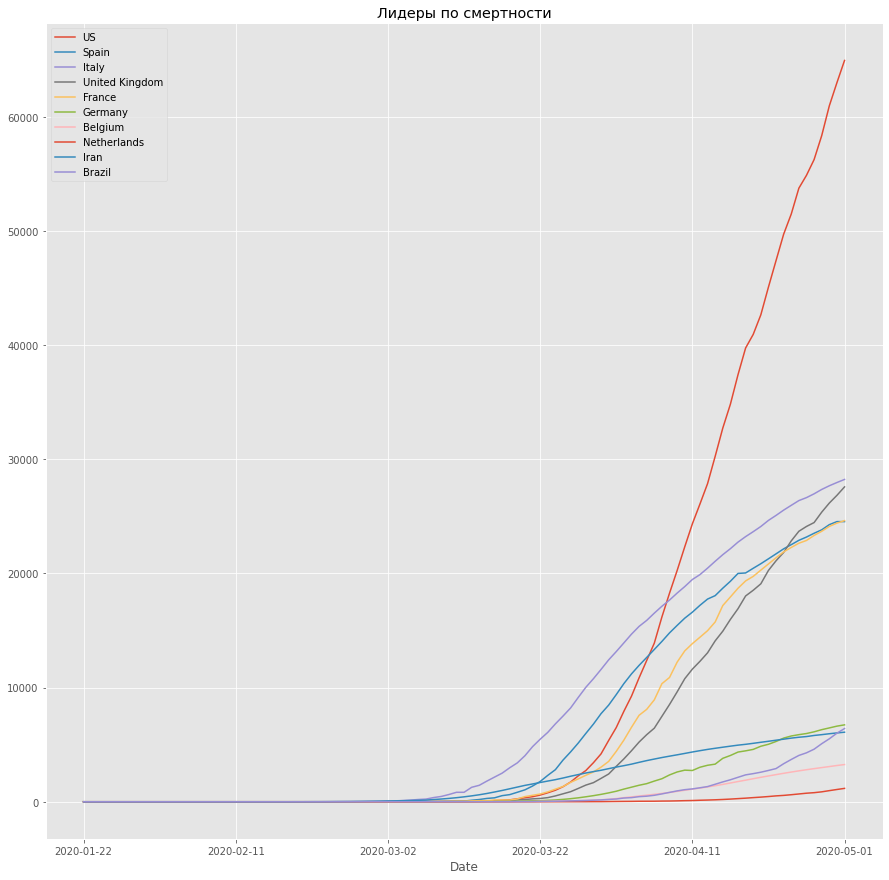

In [ ]:
df_corr_deaths.plot(kind = "line", x = 'Date', y = ['US',
 'Spain',
 'Italy',
 'United Kingdom',
 'France',
 'Germany',
 'Belgium',
 'Netherlands',
 'Iran',
 'Brazil'], title = 'Лидеры по смертности')


In [ ]:
df_corr_deaths.corr()

,US,Italy,Spain,United Kingdom,France,Germany,Belgium,Netherlands,Iran,Brazil
US,1.00,0.93,0.95,1.00,0.99,1.00,1.00,0.94,0.91,0.97
Italy,0.93,1.00,0.99,0.94,0.97,0.95,0.92,0.79,1.00,0.85
Spain,0.95,0.99,1.00,0.96,0.99,0.97,0.94,0.82,0.98,0.87
United Kingdom,1.00,0.94,0.96,1.00,0.99,1.00,1.00,0.92,0.92,0.96
France,0.99,0.97,0.99,0.99,1.00,0.99,0.98,0.88,0.95,0.92
Germany,1.00,0.95,0.97,1.00,0.99,1.00,1.00,0.92,0.93,0.96
Belgium,1.00,0.92,0.94,1.00,0.98,1.00,1.00,0.95,0.90,0.98
Netherlands,0.94,0.79,0.82,0.92,0.88,0.92,0.95,1.00,0.77,0.99
Iran,0.91,1.00,0.98,0.92,0.95,0.93,0.90,0.77,1.00,0.83
Brazil,0.97,0.85,0.87,0.96,0.92,0.96,0.98,0.99,0.83,1.00


**Лидеры по выздоровлению: ** 7 из 10 стран встречались в списках выше, что достаточно предсказуемо. Как и в предыдущих случаях, лидером является США, однако преймущество перед вторым местом, Германией, не такое значимое, как в предыдущие разы. Корреляция аналигогично показывает высокое сходство между положением в страназ. Таким образом, одновременно с ростом смертности и выявлением новых случаев, идет процесс выздоровления. 

In [ ]:
top_recovered = df.groupby('Country/Region', as_index = False)['Recovered'].max().sort_values(by = "Recovered", ascending = False)[0:10]
top_recovered

,Country/Region,Recovered
173,US,164015.00
66,Germany,126900.00
157,Spain,112050.00
85,Italy,78249.00
81,Iran,76318.00
36,China,64435.00
172,Turkey,53808.00
62,France,50212.00
23,Brazil,38039.00
162,Switzerland,23900.00


In [ ]:
dc = {'Date': df.groupby('Date').sum().index,
                         'US': list(df[df['Country/Region'] == 'US']['Recovered']),
                         'Italy': list(df[df['Country/Region'] == 'Italy']['Recovered']),
                         'Spain': list(df[df['Country/Region'] == 'Spain']['Recovered']),
                         'Turkey': list(df[df['Country/Region'] == 'Turkey']['Recovered']),
                         'France': list(df[df['Country/Region'] == 'France'].groupby(['Date'], as_index = False).sum()['Recovered']),
                         'Germany': list(df[df['Country/Region'] == 'Germany']['Recovered']),
                         'Switzerland': list(df[df['Country/Region'] == 'Turkey']['Recovered']),
                         'China': list(df[df['Country/Region'] == 'Russia']['Recovered']),
                         'Iran': list(df[df['Country/Region'] == 'Iran']['Recovered']),
                          'Brazil': list(df[df['Country/Region'] == 'Brazil']['Recovered'])
                          }
df_corr_recovered = pd.DataFrame(data=dc)
df_corr_recovered

,Date,US,Italy,Spain,Turkey,France,Germany,Switzerland,China,Iran,Brazil
0,2020-01-22,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2020-01-23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2020-01-24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,2020-01-25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,2020-01-26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...
96,2020-04-27,111424.00,66624.00,100875.00,33791.00,46293.00,114500.00,33791.00,7346.00,70933.00,31142.00
97,2020-04-28,115936.00,68941.00,102548.00,38809.00,47775.00,117400.00,38809.00,8456.00,72439.00,32544.00
98,2020-04-29,120720.00,71252.00,108947.00,44040.00,49118.00,120400.00,44040.00,10286.00,73791.00,34132.00
99,2020-04-30,153947.00,75945.00,112050.00,48886.00,50380.00,123500.00,48886.00,11619.00,75103.00,35935.00


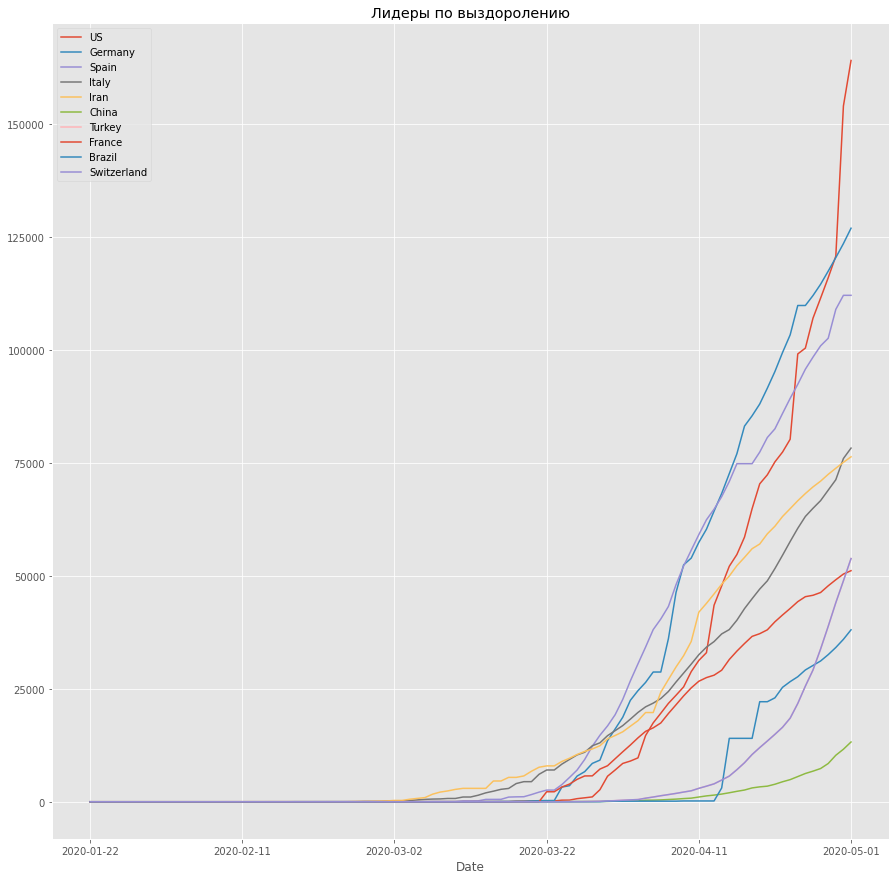

In [ ]:
df_corr_recovered.plot(kind = "line", x = 'Date', y = ['US',
 'Germany',
 'Spain',
 'Italy',
 'Iran',
 'China',
 'Turkey',
 'France',
 'Brazil',
 'Switzerland'], title = 'Лидеры по выздоролению')


In [ ]:
df_corr_recovered.corr()

,US,Italy,Spain,Turkey,France,Germany,Switzerland,China,Iran,Brazil
US,1.00,0.97,0.95,0.96,0.95,0.97,0.96,0.97,0.95,0.96
Italy,0.97,1.00,0.99,0.87,0.99,0.99,0.87,0.90,0.99,0.91
Spain,0.95,0.99,1.00,0.83,1.00,1.00,0.83,0.86,0.99,0.88
Turkey,0.96,0.87,0.83,1.00,0.83,0.86,1.00,1.00,0.83,0.95
France,0.95,0.99,1.00,0.83,1.00,1.00,0.83,0.86,1.00,0.89
Germany,0.97,0.99,1.00,0.86,1.00,1.00,0.86,0.89,0.99,0.91
Switzerland,0.96,0.87,0.83,1.00,0.83,0.86,1.00,1.00,0.83,0.95
China,0.97,0.90,0.86,1.00,0.86,0.89,1.00,1.00,0.86,0.95
Iran,0.95,0.99,0.99,0.83,1.00,0.99,0.83,0.86,1.00,0.89
Brazil,0.96,0.91,0.88,0.95,0.89,0.91,0.95,0.95,0.89,1.00


**Выводы:** 1.Тренд по всем показателям, по всем странам списка совпадает. 
2. Корреляция высокая. 3. Большинство (7 из 10) стран повторяются во всех трех списках. 4. Несмотря на то, что инфекция начала распространяться в Китае, среди лидеров не ни одной азиатской страны, кроме самого Китая по показателю выздоровевших. 5. Большинство стран - европейские. Разница между восточными и западными странами является следствием успешной/неуспешной стратегии по предотвращению распространения вируса. 6. Со значительным отрывом по всем показателям впереди находится США.


1.7 Для первых 5 стран из топ-10 и России постойте сравнительные графики. Изучите как изменялись значения отношений погибших/выздоровивших, погибших/заболевших, заболевших/общее число жителей, ваш вариант...




In [ ]:
df_confirmed_5 = df_corr_confirmed[['Date', 'US', 'Spain', 'Italy', 'United Kingdom', 'France','Russia']]
df_confirmed_5

,Date,US,Spain,Italy,United Kingdom,France,Russia
0,2020-01-22,1.00,0.00,0.00,0.00,0.00,0.00
1,2020-01-23,1.00,0.00,0.00,0.00,0.00,0.00
2,2020-01-24,2.00,0.00,0.00,0.00,2.00,0.00
3,2020-01-25,2.00,0.00,0.00,0.00,3.00,0.00
4,2020-01-26,5.00,0.00,0.00,0.00,3.00,0.00
...,...,...,...,...,...,...,...
96,2020-04-27,988197.00,209465.00,199414.00,158348.00,165963.00,87147.00
97,2020-04-28,1012582.00,210773.00,201505.00,162350.00,169053.00,93558.00
98,2020-04-29,1039909.00,212917.00,203591.00,166441.00,166543.00,99399.00
99,2020-04-30,1069424.00,213435.00,205463.00,172481.00,167299.00,106498.00


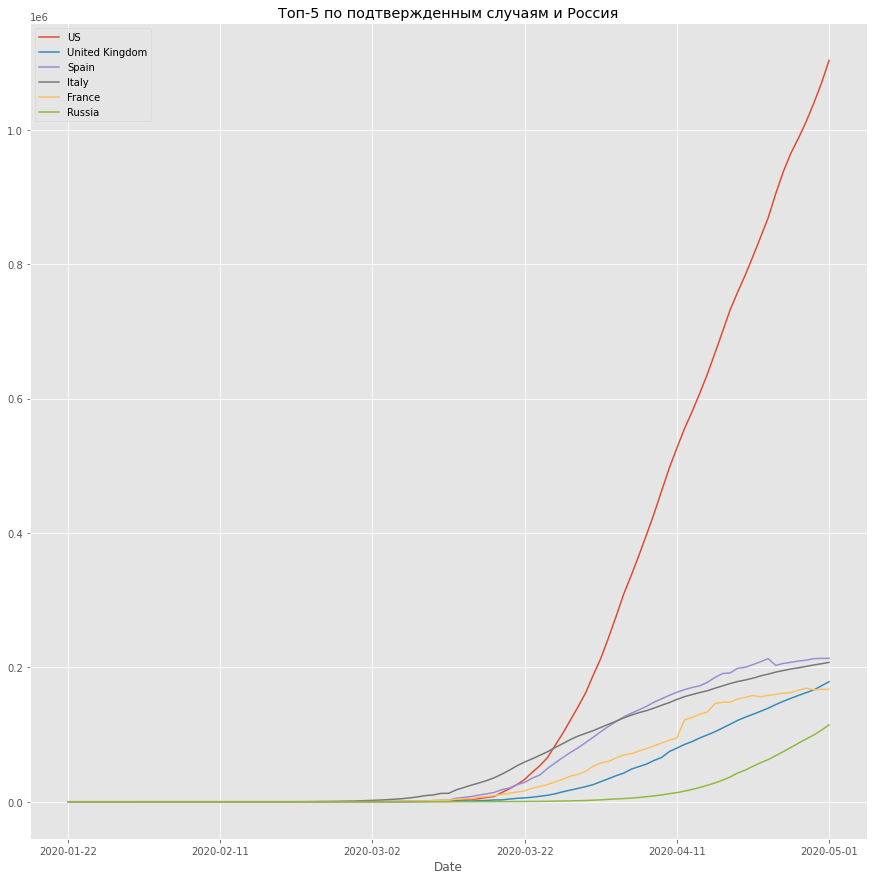

In [ ]:
df_confirmed_5.plot(kind = "line", x = 'Date', y = ['US',
 'United Kingdom',
 'Spain',
 'Italy',
 'France',
 'Russia'], title = 'Топ-5 по подтвержденным случаям и Россия')

**Вывод: **Россия относительно ТОП-5 стран занимает более выигрышное положение. Во-первых, первые случаи появились явно позже других стран. Во-вторых, кривая - вогнутая, что говорит о постепенном увеличении выявленных случаев, что способствует 

In [ ]:
df_deaths_5 = df_corr_deaths[['Date', 'US', 'Spain', 'Italy', 'United Kingdom', 'France']]
df_deaths_5['Russia'] = list(df[df['Country/Region'] == 'Russia']['Deaths'])
df_deaths_5


,Date,US,Spain,Italy,United Kingdom,France,Russia
0,2020-01-22,0.00,0.00,0.00,0.00,0.00,0.00
1,2020-01-23,0.00,0.00,0.00,0.00,0.00,0.00
2,2020-01-24,0.00,0.00,0.00,0.00,0.00,0.00
3,2020-01-25,0.00,0.00,0.00,0.00,0.00,0.00
4,2020-01-26,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...
96,2020-04-27,56259.00,23521.00,26977.00,24458.00,23327.00,794.00
97,2020-04-28,58355.00,23822.00,27359.00,25369.00,23694.00,867.00
98,2020-04-29,60967.00,24275.00,27682.00,26166.00,24121.00,972.00
99,2020-04-30,62996.00,24543.00,27967.00,26842.00,24410.00,1073.00


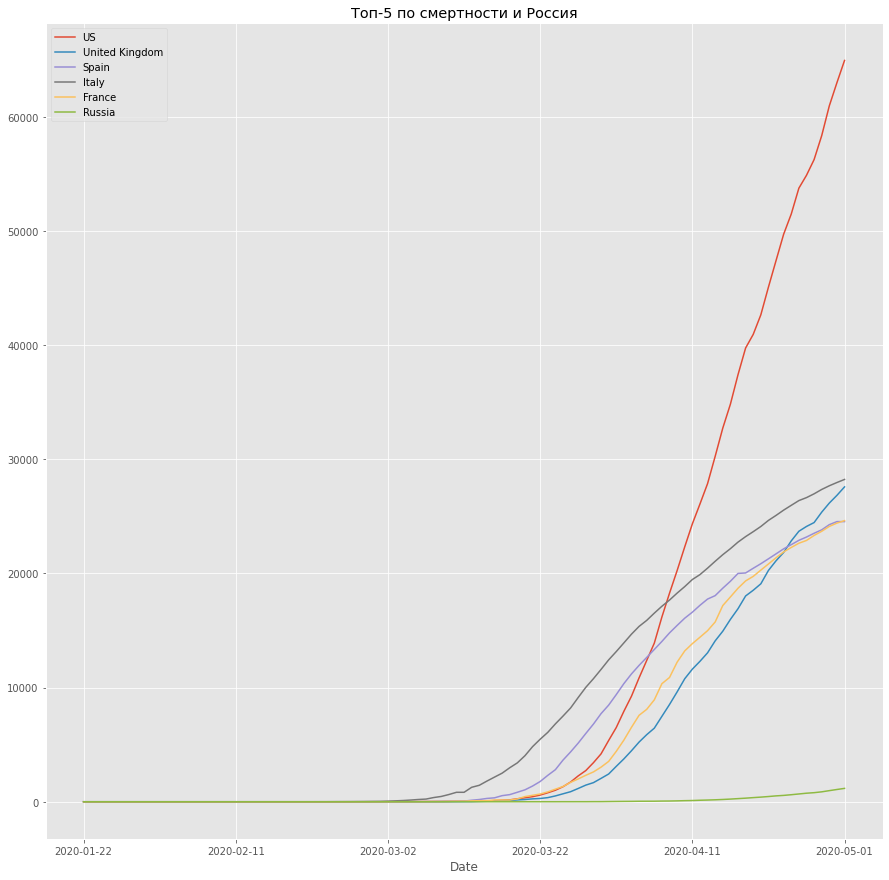

In [ ]:
df_deaths_5.plot(kind = "line", x = 'Date', y = ['US',
 'United Kingdom',
 'Spain',
 'Italy',
 'France',
 'Russia'], title = 'Топ-5 по смертности и Россия')

**Вывод:** Аналогично Россия по этому показателю находится в гораздо лучшем положении, чем другие пять стран. Значение смертности в России на 1 мая не превысило 1200 человек. Возможными факторами, повлиявшими на результат могут быть более подзнее попадание вируса на территорию страны, изоляционная стратегия, не полное соответствие данных реальной картине.

In [ ]:
df_recovered_5 = df_corr_recovered[['Date', 'US', 'Spain', 'Italy', 'Germany', 'Iran']]
df_recovered_5['Russia'] = list(df[df['Country/Region'] == 'Russia']['Recovered'])
df_recovered_5


,Date,US,Spain,Italy,Germany,Iran,Russia
0,2020-01-22,0.00,0.00,0.00,0.00,0.00,0.00
1,2020-01-23,0.00,0.00,0.00,0.00,0.00,0.00
2,2020-01-24,0.00,0.00,0.00,0.00,0.00,0.00
3,2020-01-25,0.00,0.00,0.00,0.00,0.00,0.00
4,2020-01-26,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...
96,2020-04-27,111424.00,100875.00,66624.00,114500.00,70933.00,7346.00
97,2020-04-28,115936.00,102548.00,68941.00,117400.00,72439.00,8456.00
98,2020-04-29,120720.00,108947.00,71252.00,120400.00,73791.00,10286.00
99,2020-04-30,153947.00,112050.00,75945.00,123500.00,75103.00,11619.00


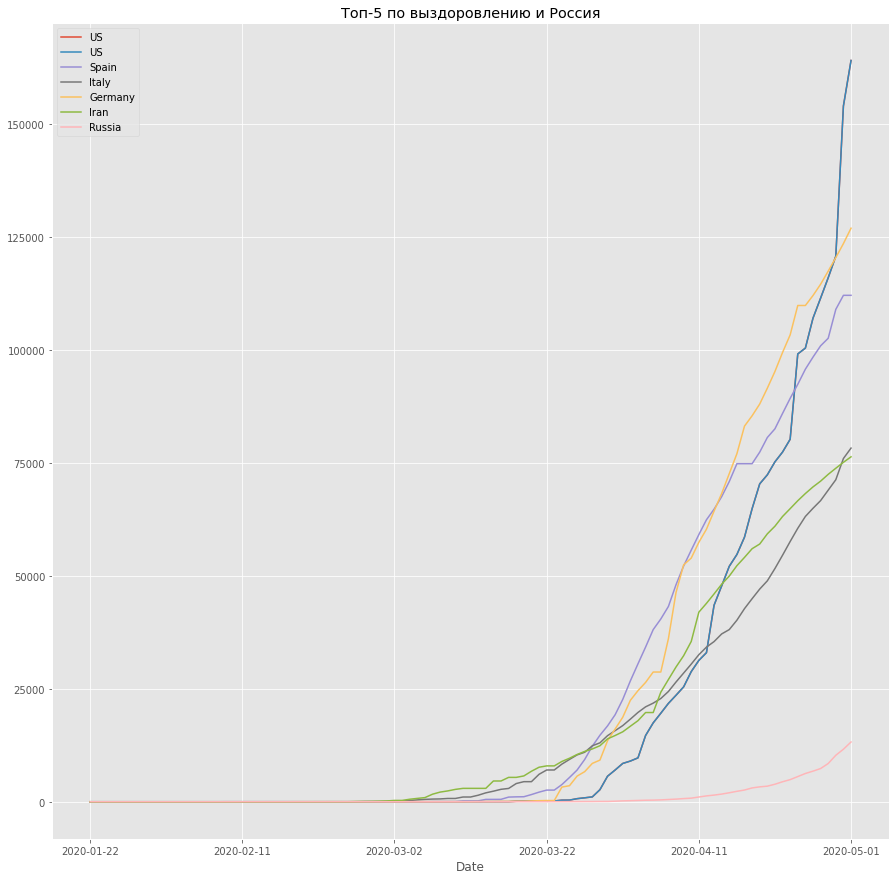

In [ ]:
df_recovered_5.plot(kind = "line", x = 'Date', y = ['US',
'US', 'Spain', 'Italy', 'Germany', 'Iran', 'Russia'], title = 'Топ-5 по выздоровлению и Россия')

**Вывод: ** Очевидно, что как и по предудыщим показателям, Россия значительно уступает Топ-5. Однако динаминамика выздоровлений положительная. Недостаточная скорость роста объясняется тем, что первые случая вируса были обнаружены позже, чем в других странах.

Затем изучаю изменения отношений погибших/выздоровивших, погибших/заболевших, выздоровивших/заболевших.

In [ ]:
list(top_confirmed['Country/Region'])

['US',
 'Spain',
 'Italy',
 'United Kingdom',
 'France',
 'Germany',
 'Turkey',
 'Russia',
 'Iran',
 'Brazil']

In [ ]:
df_recovered_5 = df_corr_recovered[['Date', 'US', 'Spain', 'Italy', 'Germany', 'Iran','United Kingdom', 'France']]
df_recovered_5['Russia'] = list(df[df['Country/Region'] == 'Russia']['Recovered'])
df_recovered_5


In [ ]:
dcc = {'Date': df.groupby('Date').sum().index,
                         'US': list(df_recovered_5['US']/df_confirmed_5['US']),
                         'Italy': list(df_recovered_5['Italy']/df_confirmed_5['Italy']),
                         'Spain': list(df_recovered_5['Spain']/df_confirmed_5['Spain']),
                         'Germany': list(df[df['Country/Region'] == 'Germany']['Recovered']/df[df['Country/Region'] == 'Germany']['Confirmed']),
                         'France': list(df[df['Country/Region'] == 'France'].groupby(['Date'], as_index = False).sum()['Recovered']/df[df['Country/Region'] == 'France'].groupby(['Date'], as_index = False).sum()['Confirmed']),
                         'Iran': list(df[df['Country/Region'] == 'Iran']['Recovered']/df[df['Country/Region'] == 'Iran']['Confirmed']),
                         'Russia': list(df_recovered_5['Russia']/df_confirmed_5['Russia'])
                          }
df_deaths_recovered = pd.DataFrame(data=dcc)
df_deaths_recovered.tail()

,Date,US,Italy,Spain,Germany,France,Iran,Russia
96,2020-04-27,0.11,0.33,0.48,0.72,0.28,0.78,0.08
97,2020-04-28,0.11,0.34,0.49,0.73,0.28,0.78,0.09
98,2020-04-29,0.12,0.35,0.51,0.75,0.29,0.79,0.10
99,2020-04-30,0.14,0.37,0.52,0.76,0.30,0.79,0.11
100,2020-05-01,0.15,0.38,0.52,0.77,0.31,0.80,0.12


In [ ]:
dcc = {'Date': df.groupby('Date').sum().index,
                         'US': list(df_recovered_5['US']/df_confirmed_5['US']),
                         'Italy': list(df_recovered_5['Italy']/df_confirmed_5['Italy']),
                         'Spain': list(df_recovered_5['Spain']/df_confirmed_5['Spain']),
                         'Germany': list(df[df['Country/Region'] == 'Germany']['Recovered']/df[df['Country/Region'] == 'Germany']['Confirmed']),
                         'France': list(df[df['Country/Region'] == 'France'].groupby(['Date'], as_index = False).sum()['Recovered']/df[df['Country/Region'] == 'France'].groupby(['Date'], as_index = False).sum()['Confirmed']),
                         'Iran': list(df[df['Country/Region'] == 'Iran']['Recovered']/df[df['Country/Region'] == 'Iran']['Confirmed']),
                         'Russia': list(df_recovered_5['Russia']/df_confirmed_5['Russia'])
                          }
df_recovered_confirmed = pd.DataFrame(data=dcc)
df_recovered_confirmed.tail()

,Date,US,Italy,Spain,Germany,France,Iran,Russia
96,2020-04-27,0.11,0.33,0.48,0.72,0.28,0.78,0.08
97,2020-04-28,0.11,0.34,0.49,0.73,0.28,0.78,0.09
98,2020-04-29,0.12,0.35,0.51,0.75,0.29,0.79,0.10
99,2020-04-30,0.14,0.37,0.52,0.76,0.30,0.79,0.11
100,2020-05-01,0.15,0.38,0.52,0.77,0.31,0.80,0.12


In [ ]:
dcc = {'Date': df.groupby('Date').sum().index,
                         'US': list(df_deaths_5['US']/df_confirmed_5['US']),
                         'Italy': list(df_deaths_5['Italy']/df_confirmed_5['Italy']),
                         'Spain': list(df_deaths_5['Spain']/df_confirmed_5['Spain']),
                         'Germany': list(df[df['Country/Region'] == 'Germany']['Deaths']/df[df['Country/Region'] == 'Germany']['Confirmed']),
                         'France': list(df[df['Country/Region'] == 'France'].groupby(['Date'], as_index = False).sum()['Deaths']/df[df['Country/Region'] == 'France'].groupby(['Date'], as_index = False).sum()['Confirmed']),
                         'Iran': list(df[df['Country/Region'] == 'Iran']['Deaths']/df[df['Country/Region'] == 'Iran']['Confirmed']),
                         'Russia': list(df_deaths_5['Russia']/df_confirmed_5['Russia'])
                          }
df_deaths_confirmed = pd.DataFrame(data=dcc)
df_deaths_confirmed.tail()

,Date,US,Italy,Spain,Germany,France,Iran,Russia
96,2020-04-27,0.06,0.14,0.11,0.04,0.14,0.06,0.01
97,2020-04-28,0.06,0.14,0.11,0.04,0.14,0.06,0.01
98,2020-04-29,0.06,0.14,0.11,0.04,0.14,0.06,0.01
99,2020-04-30,0.06,0.14,0.11,0.04,0.15,0.06,0.01
100,2020-05-01,0.06,0.14,0.11,0.04,0.15,0.06,0.01


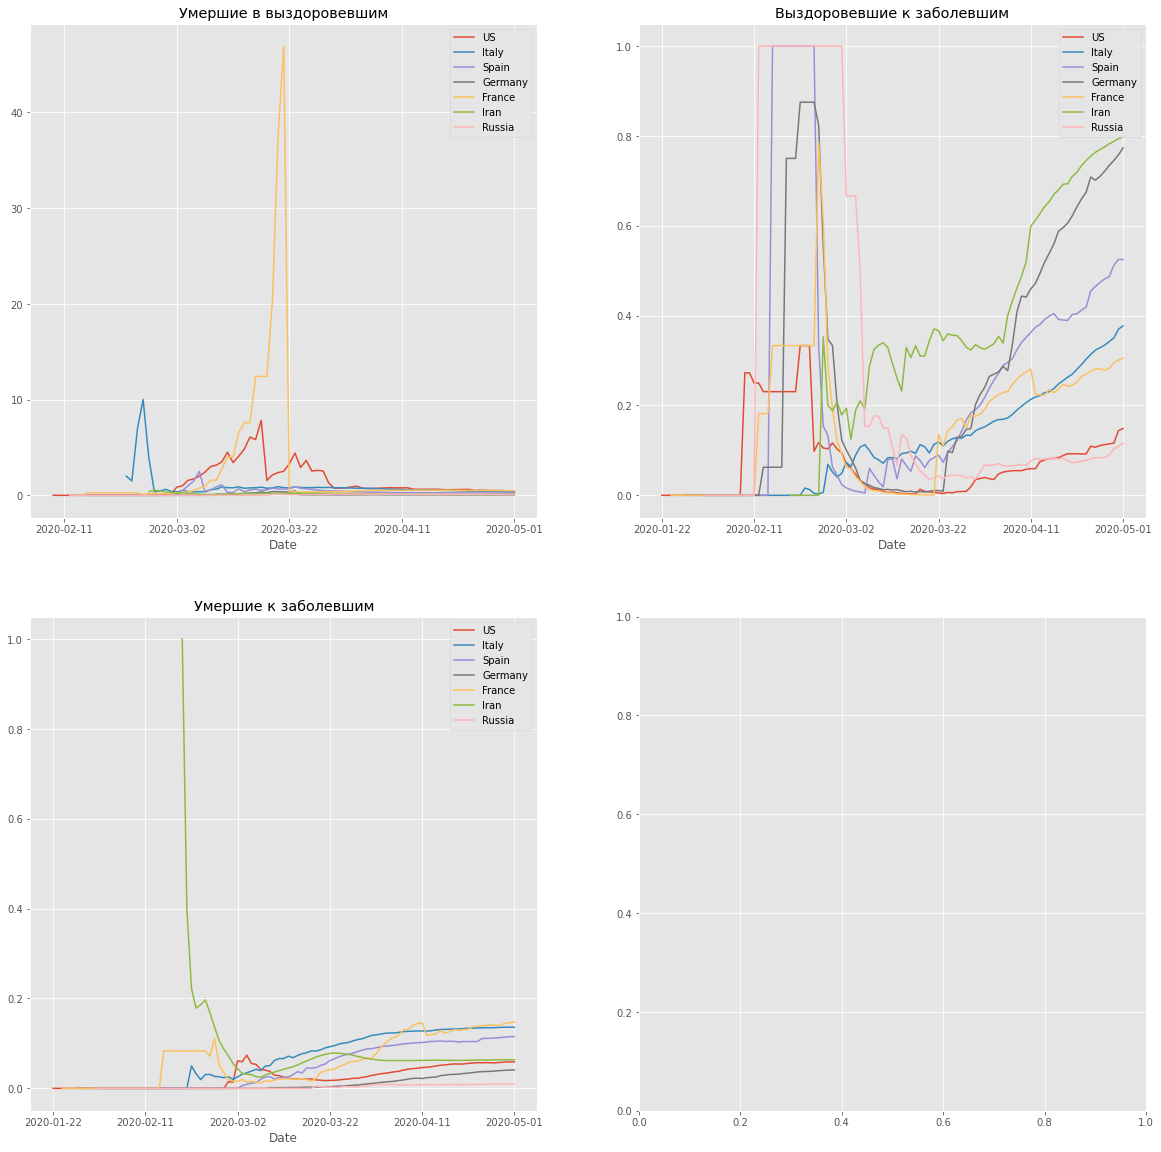

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))

df_deaths_recovered.plot(kind = "line", x = 'Date',  y = ['US',	'Italy',	'Spain', 'Germany',	'France',	'Iran',	'Russia'],  title = 'Умершие в выздоровевшим', ax=axes[0,0])

df_recovered_confirmed.plot(kind = "line", x = 'Date', y = ['US',	'Italy',	'Spain', 'Germany',	'France',	'Iran',	'Russia'], title = 'Выздоровевшие к заболевшим', ax=axes[0,1])

df_deaths_confirmed.plot(kind = "line", x = 'Date', y = ['US',	'Italy',	'Spain', 'Germany',	'France',	'Iran',	'Russia'], title = 'Умершие к заболевшим', ax=axes[1,0])


**Вывод: ** Относительно стран лидеров по умершим, выздоровевшим, заболевшим Россия находится в более выигрышном положении. 

На графиках выше видно, что вызоровевших гораздо больше, чем умерших, причем это наблюдается в всех анализируемых странах.

Скачки по некоторым странам в начале всех графиков можно обусловить недостаточной информацией о подтвержденных случаях.



1.8 Выделите временной ряд по одному из целевых признаков. Для выделенного временного ряда:
  - Представьте временной ряд в виде последовательности разницы между значениями. Рассчитайте лаги, выведите их на графике.
  - Попробуйте декомпозировать временной ряд. Постройте график тренда.
  - Что вы можете сказать о стационарности временного ряда? 

Для анализа взят временной ряд выздоровевших в Германии, поскольку этот показаль заинтересовал после предыдущего пункта. Высчитываю лаги и вывожу на графике.


In [ ]:
dg = {'Date': df.groupby('Date').sum().index,
                         'Recovered': list(df[df['Country/Region'] == 'Germany']['Recovered'])
                          }
df_Germany = pd.DataFrame(data=dg)
df_Germany.tail()


,Date,Recovered
96,2020-04-27,114500.00
97,2020-04-28,117400.00
98,2020-04-29,120400.00
99,2020-04-30,123500.00
100,2020-05-01,126900.00


In [ ]:
rec_list = list(df[df['Country/Region'] == 'Germany']['Recovered'])
diff_rec = [x - rec_list[i - 1] for i, x in enumerate(rec_list)][1:]
diff_rec.insert(0, 0) 

df_Germany["DifferenceRecovered"] = diff_rec
df_Germany.tail()

,Date,Recovered,RecoveredShift,DifferenceRecovered
2020-04-27,2020-04-27,114500.00,112000.00,2500.00
2020-04-28,2020-04-28,117400.00,114500.00,2900.00
2020-04-29,2020-04-29,120400.00,117400.00,3000.00
2020-04-30,2020-04-30,123500.00,120400.00,3100.00
2020-05-01,2020-05-01,126900.00,123500.00,3400.00


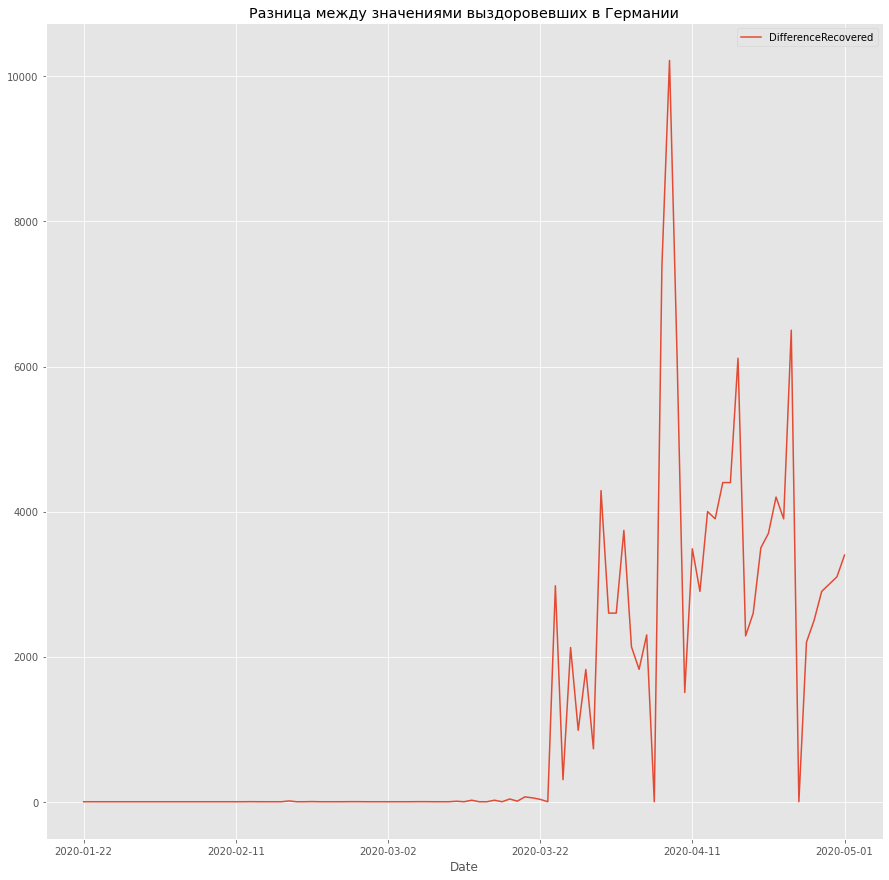

In [ ]:
df_Germany.plot(kind = "line", x = 'Date', y = "DifferenceRecovered", title = 'Разница между значениями выздоровевших в Германии')


In [ ]:
df_Germany["RecoveredShift"] = df_Germany['Recovered'].shift()
df_Germany

,Date,Recovered,RecoveredShift
0,2020-01-22,0.00,nan
1,2020-01-23,0.00,0.00
2,2020-01-24,0.00,0.00
3,2020-01-25,0.00,0.00
4,2020-01-26,0.00,0.00
...,...,...,...
96,2020-04-27,114500.00,112000.00
97,2020-04-28,117400.00,114500.00
98,2020-04-29,120400.00,117400.00
99,2020-04-30,123500.00,120400.00


In [ ]:
df_Germany.plot(kind= "scatter", y = "Recovered", x = "RecoveredShift", s = 50)


Декомпозиция

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose


In [ ]:
df_Germany.index = pd.PeriodIndex(df_Germany['Date'].values, freq='D').to_timestamp()
df_Germany

,Date,Recovered,RecoveredShift,DifferenceRecovered
2020-01-22,2020-01-22,0.00,nan,0.00
2020-01-23,2020-01-23,0.00,0.00,0.00
2020-01-24,2020-01-24,0.00,0.00,0.00
2020-01-25,2020-01-25,0.00,0.00,0.00
2020-01-26,2020-01-26,0.00,0.00,0.00
...,...,...,...,...
2020-04-27,2020-04-27,114500.00,112000.00,2500.00
2020-04-28,2020-04-28,117400.00,114500.00,2900.00
2020-04-29,2020-04-29,120400.00,117400.00,3000.00
2020-04-30,2020-04-30,123500.00,120400.00,3100.00


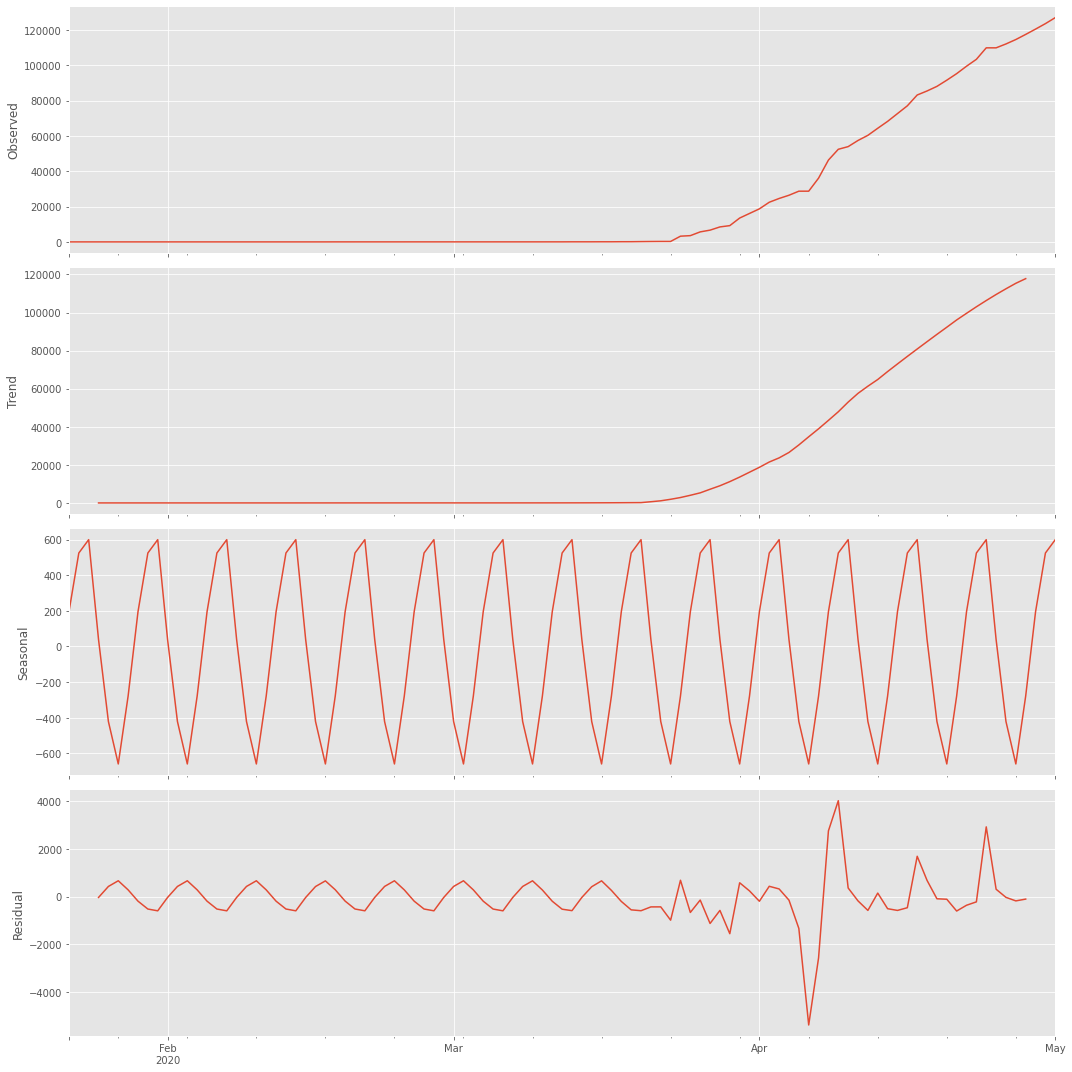

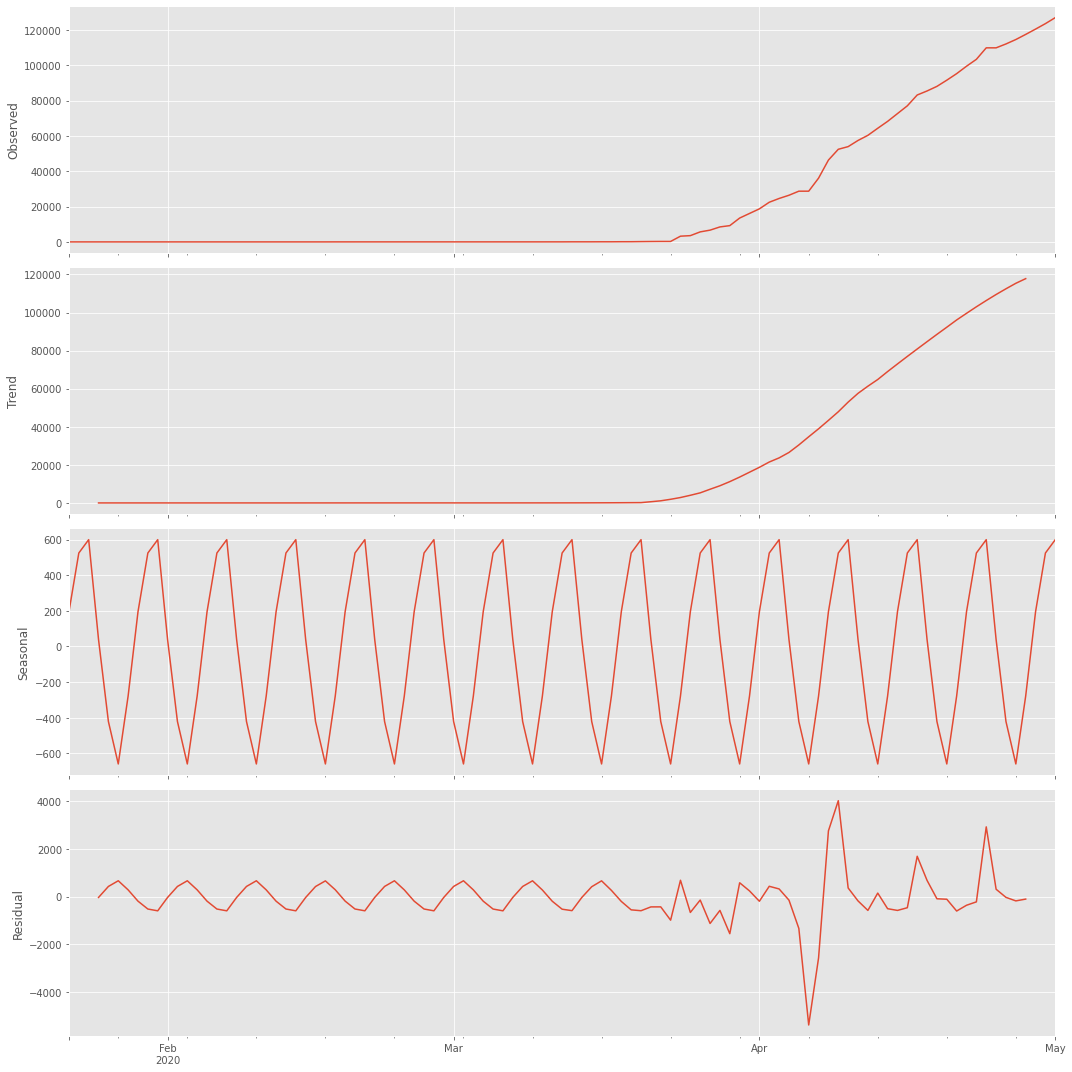

In [ ]:
decomposition = seasonal_decompose(df_Germany['Recovered'], model = "additive")
decomposition.plot()

На графике выделяется сезонность и общий тренд к росту выздоровевших.

Проверка на стационарность - ряд не стационарен, значит характеристики в дальнейшем будут отличаться от прежде наблюдаемых. Это затрудняет прогноз.

In [ ]:
import statsmodels.api as sm

test = sm.tsa.adfuller(df_Germany['Recovered'])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

adf:  -2.646757282860792
p-value:  0.08371332148197813
Critical values:  {'1%': -3.50434289821397, '5%': -2.8938659630479413, '10%': -2.5840147047458037}
Есть единичные корни, ряд не стационарен


Вывод: В случае с выздоравливающими в Германии наблюдается общий рост и сезонность, однако ряд не стационарен.

1.9 Для любого интересующего Вас временного ряда постройте графики ACF и PACF. Сделайте выводы. 

In [ ]:
from statsmodels.tsa.stattools import acf, pacf

gr = df_Germany['Recovered']
gr_diff = df_Germany['Recovered'] - df_Germany['RecoveredShift']
gr_diff.dropna(inplace = True)

lag_acf = acf(gr_diff, nlags=20)
lag_acf


array([1.        , 0.71246795, 0.59347706, 0.54630882, 0.57705879,
       0.57468278, 0.64075893, 0.63933292, 0.61913828, 0.59585947,
       0.47045937, 0.38311924, 0.4351611 , 0.42156588, 0.43934355,
       0.45210319, 0.37401782, 0.23931372, 0.19094395, 0.20795251,
       0.20809987])

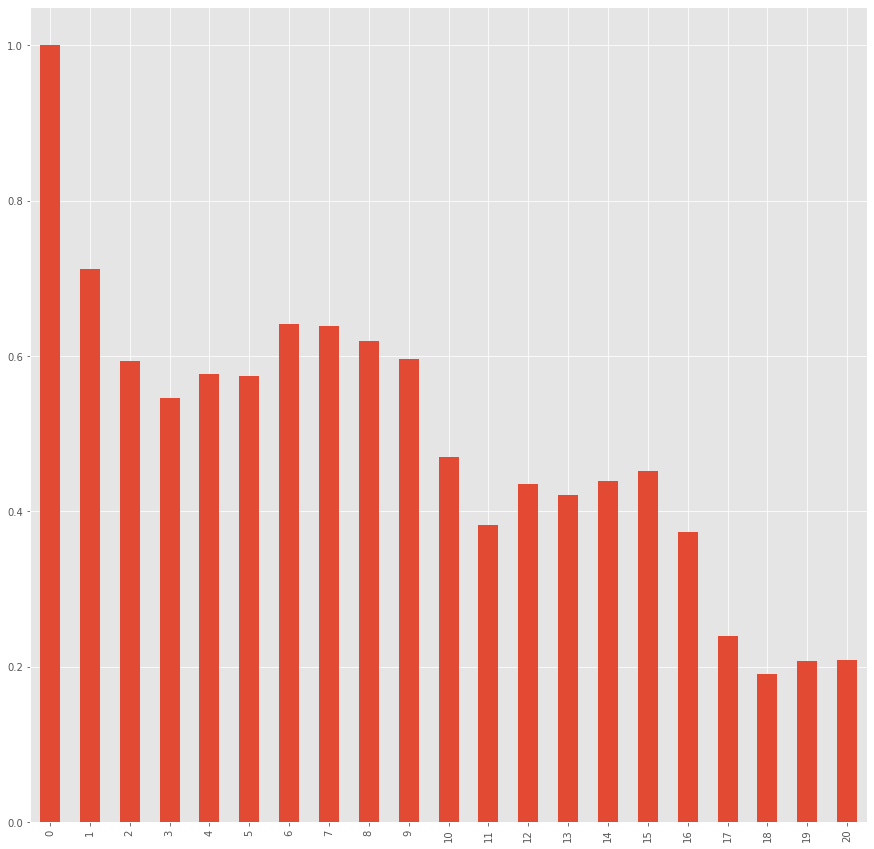

In [ ]:
ACF = pd.Series(lag_acf)
ACF.plot(kind = "bar")


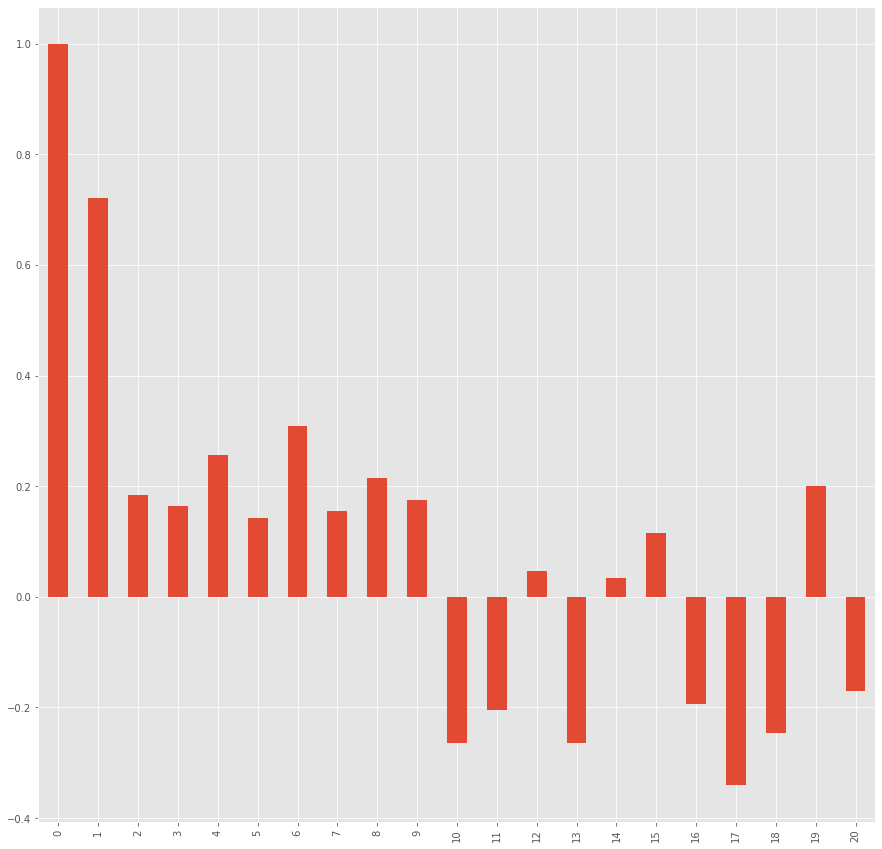

In [ ]:
lag_pacf = pacf(gr_diff, nlags=20, method='ols')
PACF = pd.Series(lag_pacf)
PACF.plot(kind = "bar")


**Выводы:** на графике ACF видно постепенное затухание и сезонность. Автокорреляция значима для большого числа лагов, но больше всего для первого. Это подтверждает график PACF, где первый лаг наиболее отличен от нуля. Таким образом, перед нами ряд первого порядка. Модель будет ARIMA (1, 1, 1).  

#### 1.10. Изучаемый Вами датасет отражает текущую мировую статистику распространения болезни. Однако эти данные не дают нам возможноси предположить о возможных факторах, которые влюяют на скорость распространения, летальности, заразность и тд. Поэтому в наш датасет можно добавить новые признаки из других наборов данных, которые могут не только помочь при прогнозировании временного ряда, но и определить наиболее значимые факторы.

- Добавьте новый признак "количество дней со дня первого случая заражения". Добавьте еще не менее 5 новых признаков в датасет, которые могут быть значимым фактором распространения вируса. Сохраните полученный датасет, вы можете его использовать во второй части домашнего задания.
- Исследуйте как добавленные признаки соотносятся с трендами распространения короновируса в некоторых странах. Сделайте выводы.

*Примеры признаков - количество дней со начала карантина, конинент, плотность населения, количество употребляемого алкоголя, летучих мышей, алкоголя, крокодилов на душу населения, количество туристов в год, уровень безработицы, температура, количество игроков в Plague Inc., средний возраст или продолжительность жизни и так далее. Вы можете использовать любой найденный датасет. Главное, чтобы у Вас получилось скомбинировать данные.*

  Примеры датасеты:
  1. [500 Cities: Local Data for Better Health (2019)](https://www.kaggle.com/jaimeblasco/500-cities-local-data-for-better-health-2019)
  2. [Daily global surface summary from over 9000 weather stations from 1929 to now](https://www.kaggle.com/noaa/gsod)
  3. [Population by Country - 2020](https://www.kaggle.com/tanuprabhu/population-by-country-2020)



Добавляю признак количество дней с начала карантина

In [ ]:
df_new = df

In [ ]:
df_countries_days_2 = df_countries_days.rename({'Countries': 'Country/Region'}, axis=1)

In [ ]:
df_countries_days_2.head()

,Country/Region,First_day,Number_of_days_from_first_case
0,Afghanistan,2020-02-24,67 days
1,Albania,2020-03-09,53 days
2,Algeria,2020-02-25,66 days
3,Andorra,2020-03-02,60 days
4,Angola,2020-03-20,42 days


In [ ]:
df_new = pd.merge(df_new,df_countries_days_2[['Country/Region','First_day']],on='Country/Region', how='left', validate="many_to_many")
df_new

,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths,First_day
0,2020-01-22,Afghanistan,NaN,33.00,65.00,0.00,0.00,0.00,2020-02-24
1,2020-01-23,Afghanistan,NaN,33.00,65.00,0.00,0.00,0.00,2020-02-24
2,2020-01-24,Afghanistan,NaN,33.00,65.00,0.00,0.00,0.00,2020-02-24
3,2020-01-25,Afghanistan,NaN,33.00,65.00,0.00,0.00,0.00,2020-02-24
4,2020-01-26,Afghanistan,NaN,33.00,65.00,0.00,0.00,0.00,2020-02-24
...,...,...,...,...,...,...,...,...,...
26861,2020-04-27,Zimbabwe,NaN,-20.00,30.00,32.00,5.00,4.00,2020-03-20
26862,2020-04-28,Zimbabwe,NaN,-20.00,30.00,32.00,5.00,4.00,2020-03-20
26863,2020-04-29,Zimbabwe,NaN,-20.00,30.00,32.00,5.00,4.00,2020-03-20
26864,2020-04-30,Zimbabwe,NaN,-20.00,30.00,40.00,5.00,4.00,2020-03-20


In [ ]:
difference = list(pd.to_datetime(df_new['Date']) - pd.to_datetime(df_new['First_day']))

df_new['Number_of_days_from_first_case'] = difference
df_new.tail()

,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths,First_day,Number_of_days_from_first_case
26861,2020-04-27,Zimbabwe,NaN,-20.00,30.00,32.00,5.00,4.00,2020-03-20,38 days
26862,2020-04-28,Zimbabwe,NaN,-20.00,30.00,32.00,5.00,4.00,2020-03-20,39 days
26863,2020-04-29,Zimbabwe,NaN,-20.00,30.00,32.00,5.00,4.00,2020-03-20,40 days
26864,2020-04-30,Zimbabwe,NaN,-20.00,30.00,40.00,5.00,4.00,2020-03-20,41 days
26865,2020-05-01,Zimbabwe,NaN,-20.00,30.00,40.00,5.00,4.00,2020-03-20,42 days


Удаляю строки с данными, где Number_of_days_from_first_case < 0

In [ ]:
df_new = df_new[df_new['Number_of_days_from_first_case'] >= '0 days 00:00:00'] 
df_new.head()

,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths,First_day,Number_of_days_from_first_case
33,2020-02-24,Afghanistan,NaN,33.00,65.00,1.00,0.00,0.00,2020-02-24,0 days
34,2020-02-25,Afghanistan,NaN,33.00,65.00,1.00,0.00,0.00,2020-02-24,1 days
35,2020-02-26,Afghanistan,NaN,33.00,65.00,1.00,0.00,0.00,2020-02-24,2 days
36,2020-02-27,Afghanistan,NaN,33.00,65.00,1.00,0.00,0.00,2020-02-24,3 days
37,2020-02-28,Afghanistan,NaN,33.00,65.00,1.00,0.00,0.00,2020-02-24,4 days


**Добавляю признаки:** 
Из датасета population_by_country_2020:
1. Плотность населения (может влиять на скорость распростанения)
2. Численнсоть населения (оценить процент заболевший ко всему населению)
3. Площадь (чтобы оценить распространение)
4. Процент городских жителей (аналогично плотности населения. Люди в городах находятся в более тесном контакте друг с другом, как следствие, имеют больше шансов заразиться)
5. Средний возраст населения (поскольку люди старшего возраста более уязвимы к вируса)

In [ ]:
df_population_by_country = pd.read_csv('/content/drive/My Drive/population_by_country_2020.csv')
df_population_by_country.head()

,Country (or dependency),Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,China,1438207241,0.39 %,5540090,153,9388211,-348399.00,1.7,38,61 %,18.47 %
1,India,1377233523,0.99 %,13586631,464,2973190,-532687.00,2.2,28,35 %,17.70 %
2,United States,330610570,0.59 %,1937734,36,9147420,954806.00,1.8,38,83 %,4.25 %
3,Indonesia,272931713,1.07 %,2898047,151,1811570,-98955.00,2.3,30,56 %,3.51 %
4,Pakistan,219992900,2.00 %,4327022,287,770880,-233379.00,3.6,23,35 %,2.83 %


Название США в таблицах не совпадает. Меняю его.

In [ ]:
df_population_by_country = df_population_by_country.rename({'Country (or dependency)': 'Country/Region'}, axis=1)
df_population_by_country = df_population_by_country.replace("United States", "US")
df_population_by_country.tail()

,Country/Region,Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
230,Montserrat,4991,0.06 %,3,50,100,nan,N.A.,N.A.,10 %,0.00 %
231,Falkland Islands,3458,3.05 %,103,0,12170,nan,N.A.,N.A.,66 %,0.00 %
232,Niue,1624,0.68 %,11,6,260,nan,N.A.,N.A.,46 %,0.00 %
233,Tokelau,1354,1.27 %,17,136,10,nan,N.A.,N.A.,0 %,0.00 %
234,Holy See,801,0.25 %,2,2003,0,nan,N.A.,N.A.,N.A.,0.00 %


In [ ]:
df_new_2 = pd.merge(df_new, df_population_by_country[['Country/Region','Population (2020)', 'Density (P/Km²)', 'Urban Pop %', 'Med. Age', 'Land Area (Km²)']],on='Country/Region', how='left', validate="many_to_many")
df_new_2.tail()

,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths,First_day,Number_of_days_from_first_case,Population (2020),Density (P/Km²),Urban Pop %,Med. Age,Land Area (Km²)
18506,2020-04-27,Zimbabwe,NaN,-20.00,30.00,32.00,5.00,4.00,2020-03-20,38 days,14818157.00,38.00,38 %,19,386850.00
18507,2020-04-28,Zimbabwe,NaN,-20.00,30.00,32.00,5.00,4.00,2020-03-20,39 days,14818157.00,38.00,38 %,19,386850.00
18508,2020-04-29,Zimbabwe,NaN,-20.00,30.00,32.00,5.00,4.00,2020-03-20,40 days,14818157.00,38.00,38 %,19,386850.00
18509,2020-04-30,Zimbabwe,NaN,-20.00,30.00,40.00,5.00,4.00,2020-03-20,41 days,14818157.00,38.00,38 %,19,386850.00
18510,2020-05-01,Zimbabwe,NaN,-20.00,30.00,40.00,5.00,4.00,2020-03-20,42 days,14818157.00,38.00,38 %,19,386850.00


Из общей таблицы выделяю значения на последний день и расчитывают отношение заболевших к численности, плотности населения и площади страны.

In [ ]:
df_new_2_ld = df_new_2[(df_new_2['Date'] == last_day)]
df_new_2_ld['conf/population'] = df_new_2['Confirmed']/df_new_2['Population (2020)'] 
df_new_2_ld['conf/area'] = df_new_2['Confirmed']/df_new_2['Land Area (Km²)'] 

In [ ]:
df_new_2_ld.sort_values(by ='conf/population', ascending = False)[['Country/Region','conf/population']][0:15]

,Country/Region,conf/population
15132,San Marino,0.02
10752,Holy See,0.01
249,Andorra,0.01
12455,Luxembourg,0.01
10927,Iceland,0.01
14724,Qatar,0.00
15856,Spain,0.00
1737,Belgium,0.00
11285,Ireland,0.00
16210,Switzerland,0.00


На первых местах стоят страны с малой численностью населения, поэтому их показатель здесь достаточно высок. Однако лидеры по количеству заболевших идут сразу после них, в том числе Испания, Италия, США. Это щее раз подтверждает серьезное полоении в этих странах. Однако России здесь нет, что является хорошим показателем.

In [ ]:
df_new_2_ld.sort_values(by ='conf/area', ascending = False)[['Country/Region','conf/area']][0:15]

,Country/Region,conf/area
10752,Holy See,inf
13086,Monaco,95.00
15518,Singapore,24.43
15132,San Marino,9.67
1484,Bahrain,4.17
12716,Maldives,1.64
1737,Belgium,1.62
249,Andorra,1.59
12455,Luxembourg,1.47
12810,Malta,1.46


Аналогично, маленькие страны лидируют по показателю заражений 

Далее анализирую топ стран по заболевшим, смотря на такие критерии, как городское население, средний возраст, плотность населения


In [ ]:
df_new_top_conf = pd.merge(top_confirmed,df_new_2_ld[['Country/Region','Urban Pop %', 'Med. Age', 'Density (P/Km²)']],on='Country/Region', how='left', validate="many_to_many")
df_new_top_conf.drop_duplicates()

,Country/Region,Confirmed,Urban Pop %,Med. Age,Density (P/Km²)
0,US,1103461.00,83 %,38,36.00
1,Spain,213435.00,80 %,45,94.00
2,Italy,207428.00,69 %,47,206.00
3,United Kingdom,177454.00,83 %,40,281.00
14,France,167605.00,82 %,42,119.00
25,Germany,164077.00,76 %,46,240.00
26,Turkey,122392.00,76 %,32,110.00
27,Russia,114431.00,74 %,40,9.00
28,Iran,95646.00,76 %,32,52.00
29,Brazil,92202.00,88 %,33,25.00


У всех стран процент городского населения высокий.

Средний возраст в Италии 47, что вполне могло повлиять на количество больных и высокую смертность. Аналогичную ситуацию можно увидеть в Испании.

В России низкая плотность населения, что тоже тормозило распространению эпидемии.

США, тем не менее, не является лидеров не по одному из критериев. Значит на рпспространение вруса на территории этой страны повлияли другие факторы.

**Вывод:** У стран из Топ заразившихся аналогично высокие опказатели по числу случаев короновируса к площади и численности населения. Однако их обгоняют маленькие страны, например, Монако, но их абсолютные показатели очевидно невелики.

У лидеров по числу больных везде одинаково высокий процент городских жителей, но разная плотность населения. Можно предположить, что на распространение вируса повлияло что-то другое.



### 1.11 Выводы
1. Исходя из данных, вирус распространился в 187 стране мира. Заболевших насчитывается больше 3 миллионов, треть из которых выздоровела.
2. В большинстве стран первые случаи короновируса были зарегистрированы ранее месяца назад (до 1 апреля).
3. В странах заражение прохоило по разным сценариям, однако можно выделить некоторые частные патерны. Например, скачок летальности в начале распросранения, который обусловлен малым числов выявленных заражений. Затем падение показателя летальности и постепенный рост.
4. Лидеры по числу заболевших: США, Испания, Италия, Великобритания, Франция, Германия, Турция, Россия, Иран, Бразилия. В списках по выздоровевшим и заболевшим большинсто (7 из 10) стран повторяются. Больше всего в перечнях европейских стран. 
5. Тренд по странам лидерам совпадает, корреляция высокая.
6. Несмотря на то, что Россия попала в лидеры по заболевшим, относительно перечисленных стран находится в выигрышном положении (по числу выздоровевших к умершим, умершим к больным, выздоровевшим и больным)

## 2. Прогнозирование временного ряда

Теперь вам предстоит построить несколько моделей и спрогнозировать временной ряд для такого показателя как летальности от вируса. Летальность можно рассчитывать по формуле:

$$ CFR = \frac{Deaths}{Confirmed} $$

Для каждого типа модели сделайте несколько прогнозов для не менее 3 разных стран/регионов/другое (на ваш обоснованный выбор). Главное, чтобы каждый из типов моделей прознозировал одинаковый набор данных, чтобы в конце можно было сделать выводы о качестве работы той или иной модели.

Метрика качества RMSE. Не забудьте разбить данные временной ряд на данные для обучения и тестовые.

Не забывайте сопровождать ваш код комментариями, графиками и выводами.


---
Для анализа выбираю: 

1. США, как лидера по всем показателям - подтвержденным случаям, смертности, выздоровлению.
2. Россию, поскольку важна как для жителя этой страны. К тому же в России активно применяются карантинные меры.
3. Швецию, так как является интересным случаем борьбы с вирусом без введения запретов.

Вычисляю летальность и чищу данные, удаляя те дни, где этот показатель равен 0.

In [ ]:
df_US_cfr = df[df['Country/Region'] == 'US']
df_US_cfr['CFR'] = df_US_cfr['Deaths']/df_US_cfr['Confirmed']
df_US_cfr = df_US_cfr[df_US_cfr['CFR'] > 0]
df_US_cfr.tail()

,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths,CFR
24538,2020-04-27,US,NaN,37.09,-95.71,988197.00,111424.00,56259.00,0.06
24539,2020-04-28,US,NaN,37.09,-95.71,1012582.00,115936.00,58355.00,0.06
24540,2020-04-29,US,NaN,37.09,-95.71,1039909.00,120720.00,60967.00,0.06
24541,2020-04-30,US,NaN,37.09,-95.71,1069424.00,153947.00,62996.00,0.06
24542,2020-05-01,US,NaN,37.09,-95.71,1103461.00,164015.00,64943.00,0.06


In [ ]:
df_Russia_cfr = df[df['Country/Region'] == 'Russia']
df_Russia_cfr['CFR'] = df_Russia_cfr['Deaths']/df_Russia_cfr['Confirmed']
df_Russia_cfr = df_Russia_cfr[df_Russia_cfr['CFR'] > 0]
df_Russia_cfr.tail()

,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths,CFR
21104,2020-04-27,Russia,NaN,60.00,90.00,87147.00,7346.00,794.00,0.01
21105,2020-04-28,Russia,NaN,60.00,90.00,93558.00,8456.00,867.00,0.01
21106,2020-04-29,Russia,NaN,60.00,90.00,99399.00,10286.00,972.00,0.01
21107,2020-04-30,Russia,NaN,60.00,90.00,106498.00,11619.00,1073.00,0.01
21108,2020-05-01,Russia,NaN,60.00,90.00,114431.00,13220.00,1169.00,0.01


In [ ]:
df_Sweden_cfr = df[df['Country/Region'] == 'Sweden']
df_Sweden_cfr['CFR'] = df_Sweden_cfr['Deaths']/df_Sweden_cfr['Confirmed']
df_Sweden_cfr = df_Sweden_cfr[df_Sweden_cfr['CFR'] > 0]
df_Sweden_cfr.tail()

,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths,CFR
23326,2020-04-27,Sweden,NaN,63.00,16.00,18926.00,1005.00,2274.00,0.12
23327,2020-04-28,Sweden,NaN,63.00,16.00,19621.00,1005.00,2355.00,0.12
23328,2020-04-29,Sweden,NaN,63.00,16.00,20302.00,1005.00,2462.00,0.12
23329,2020-04-30,Sweden,NaN,63.00,16.00,21092.00,1005.00,2586.00,0.12
23330,2020-05-01,Sweden,NaN,63.00,16.00,21520.00,1005.00,2653.00,0.12


In [ ]:
#Добавляем индексы и разбиваем выборку
import numpy as np 

df_US_cfr['Date'] = pd.DatetimeIndex(df_US_cfr['Date'])
df_US_cfr.index = pd.PeriodIndex(df_US_cfr['Date'], freq='D')

df_Russia_cfr['Date'] = pd.DatetimeIndex(df_Russia_cfr['Date'])
df_Russia_cfr.index = pd.PeriodIndex(df_Russia_cfr['Date'], freq='D')

df_Sweden_cfr['Date'] = pd.DatetimeIndex(df_Sweden_cfr['Date'])
df_Sweden_cfr.index = pd.PeriodIndex(df_Sweden_cfr['Date'], freq='D')

us_train_set, us_test_set= np.split(df_US_cfr, [int(.75 *len(df_US_cfr))])
rus_train_set, rus_test_set= np.split(df_Russia_cfr, [int(.75 *len(df_Russia_cfr))])
sw_train_set, sw_test_set= np.split(df_Sweden_cfr, [int(.75 *len(df_Sweden_cfr))])

In [ ]:
us_train_set

,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths,CFR,CFR_season,CFR_season_diff
Date,,,,,,,,,,,
2020-02-29,2020-02-29,US,NaN,37.09,-95.71,68.00,7.00,1.00,0.01,nan,nan
2020-03-01,2020-03-01,US,NaN,37.09,-95.71,74.00,7.00,1.00,0.01,-0.00,nan
2020-03-02,2020-03-02,US,NaN,37.09,-95.71,98.00,7.00,6.00,0.06,0.05,0.05
2020-03-03,2020-03-03,US,NaN,37.09,-95.71,118.00,7.00,7.00,0.06,-0.00,-0.05
2020-03-04,2020-03-04,US,NaN,37.09,-95.71,149.00,7.00,11.00,0.07,0.01,0.02
2020-03-05,2020-03-05,US,NaN,37.09,-95.71,217.00,7.00,12.00,0.06,-0.02,-0.03
2020-03-06,2020-03-06,US,NaN,37.09,-95.71,262.00,7.00,14.00,0.05,-0.00,0.02
2020-03-07,2020-03-07,US,NaN,37.09,-95.71,402.00,7.00,17.00,0.04,-0.01,-0.01
2020-03-08,2020-03-08,US,NaN,37.09,-95.71,518.00,7.00,21.00,0.04,-0.00,0.01


In [ ]:
def RMSE(predicted, actual):
    mse = (predicted - actual)**2
    rmse = np.sqrt(mse.sum()/mse.count())
    return rmse

Перед началом моделирования проверю данные на стационарность. 

In [ ]:
test = sma.tsa.adfuller(us_train_set['CFR'])

print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

adf:  0.1829857728033307
p-value:  0.9712910091366292
Critical values:  {'1%': -3.6155091011809297, '5%': -2.941262357486514, '10%': -2.6091995013850418}
Есть единичные корни, ряд не стационарен


In [ ]:
test = sma.tsa.adfuller(rus_train_set['CFR'])

print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

adf:  -2.2092633974976392
p-value:  0.2029005735927188
Critical values:  {'1%': -3.6996079738860943, '5%': -2.9764303469999494, '10%': -2.627601001371742}
Есть единичные корни, ряд не стационарен


In [ ]:
test = sma.tsa.adfuller(sw_train_set['CFR'])

print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

adf:  1.317349650671793
p-value:  0.9967043328616166
Critical values:  {'1%': -3.639224104416853, '5%': -2.9512301791166293, '10%': -2.614446989619377}
Есть единичные корни, ряд не стационарен


К сожалению, нестационарны все три случая. Привожу ряд к стационарности.

In [ ]:
from statsmodels.tsa.stattools import acf, pacf

us_train_set['CFR_season'] = us_train_set['CFR']- us_train_set['CFR'].shift(1)
us_train_set['CFR_season_diff'] = us_train_set['CFR_season'] - us_train_set['CFR_season'].shift(1)
us_train_set['CFR_season_diff'].dropna(inplace = True)

rus_train_set['CFR_season'] = rus_train_set['CFR']- rus_train_set['CFR'].shift(1)
rus_train_set['CFR_season_diff'] = rus_train_set['CFR_season'] - rus_train_set['CFR_season'].shift(1)
rus_train_set['CFR_season_diff'].dropna(inplace = True)

sw_train_set['CFR_season'] = sw_train_set['CFR']- sw_train_set['CFR'].shift(1)
sw_train_set['CFR_season_diff'] = sw_train_set['CFR_season'] - sw_train_set['CFR_season'].shift(1)
sw_train_set['CFR_season_diff'].dropna(inplace = True)


In [ ]:
us_train_set['CFR_season_diff']

In [ ]:
us_test_set['CFR_season'] = us_test_set['CFR']- us_test_set['CFR'].shift(1)
us_test_set['CFR_season_diff'] = us_test_set['CFR_season'] - us_test_set['CFR_season'].shift(1)
us_test_set['CFR_season_diff'].dropna(inplace = True)

rus_test_set['CFR_season'] = rus_test_set['CFR']- rus_test_set['CFR'].shift(1)
rus_test_set['CFR_season_diff'] = rus_test_set['CFR_season'] - rus_test_set['CFR_season'].shift(1)
rus_test_set['CFR_season_diff'].dropna(inplace = True)

sw_test_set['CFR_season'] = sw_test_set['CFR']- sw_test_set['CFR'].shift(1)
sw_test_set['CFR_season_diff'] = sw_test_set['CFR_season'] - sw_test_set['CFR_season'].shift(1)
sw_test_set['CFR_season_diff'].dropna(inplace = True)


In [ ]:
test = sma.tsa.adfuller(us_train_set['CFR_season_diff'].dropna())

print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

adf:  -3.2533688242337453
p-value:  0.01709598719044479
Critical values:  {'1%': -3.639224104416853, '5%': -2.9512301791166293, '10%': -2.614446989619377}
Единичных корней нет, ряд стационарен


In [ ]:
test = sma.tsa.adfuller(rus_train_set['CFR_season_diff'].dropna())

print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

adf:  -3.477728226785337
p-value:  0.00857784596787377
Critical values:  {'1%': -3.7238633119999998, '5%': -2.98648896, '10%': -2.6328004}
Единичных корней нет, ряд стационарен


In [ ]:
test = sma.tsa.adfuller(sw_train_set['CFR_season_diff'].dropna())

print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

adf:  -5.044081941864544
p-value:  1.814117486667787e-05
Critical values:  {'1%': -3.661428725118324, '5%': -2.960525341210433, '10%': -2.6193188033298647}
Единичных корней нет, ряд стационарен


2.1, 2.2, 2.10 - считаю для CFR. Остальное для CFR_season_diff

### 2.1 Прогнозирование средним (Mean Constant Model)

In [ ]:
mean_us = us_train_set['CFR'].mean()
RMSE_mean_us = RMSE(mean_us, us_test_set['CFR'])
us_test_set['CFR_mean'] = mean_us

mean_rus = rus_train_set['CFR'].mean()
RMSE_mean_rus = RMSE(mean_rus, rus_test_set['CFR'])
rus_test_set['CFR_mean'] = mean_rus

mean_sw = sw_train_set['CFR'].mean()
RMSE_mean_sw = RMSE(mean_sw, sw_test_set['CFR'])
sw_test_set['CFR_mean'] = mean_sw

In [ ]:
pd.options.display.float_format = '{:,.4f}'.format

df_Results = pd.DataFrame(columns = ["Model", "Forecast_US", "RMSE_US", "Forecast_Russia", "RMSE_Russia", "Forecast_Sweden", "RMSE_Sweden"])

df_Results.loc[0,"Model"] = "Mean"
df_Results.loc[0,"Forecast_US"] = mean_us
df_Results.loc[0,"RMSE_US"] = RMSE_mean_us
df_Results.loc[0,"Forecast_Russia"] = mean_rus
df_Results.loc[0,"RMSE_Russia"] = RMSE_mean_rus
df_Results.loc[0,"Forecast_Sweden"] = mean_sw
df_Results.loc[0,"RMSE_Sweden"] = RMSE_mean_sw
df_Results.head()

,Model,Forecast_US,RMSE_US,Forecast_Russia,RMSE_Russia,Forecast_Sweden,RMSE_Sweden
0,Mean,0.0331,0.0232,0.0065,0.0028,0.0454,0.0732


### 2.2 Линейная модель (Linear Trend Model)

In [ ]:
us_train_set["timeIndex"] = us_train_set['Date'] - us_train_set['Date'].min()
us_train_set["timeIndex"] =  us_train_set["timeIndex"]/np.timedelta64(1, 'D')

rus_train_set["timeIndex"] = rus_train_set['Date'] - rus_train_set['Date'].min()
rus_train_set["timeIndex"] =  rus_train_set["timeIndex"]/np.timedelta64(1, 'D')

sw_train_set["timeIndex"] = sw_train_set['Date'] - sw_train_set['Date'].min()
sw_train_set["timeIndex"] =  sw_train_set["timeIndex"]/np.timedelta64(1, 'D')

In [ ]:
import statsmodels.formula.api as smf

model_linear_us = smf.ols('CFR ~ timeIndex', data = us_train_set).fit()
model_linear_rus = smf.ols('CFR ~ timeIndex', data = rus_train_set).fit()
model_linear_sw = smf.ols('CFR ~ timeIndex', data = sw_train_set).fit()

pr_us = model_linear_us.predict()
pr_rus = model_linear_rus.predict()
pr_sw = model_linear_sw.predict()

In [ ]:
pr_us = pr_us[:len(us_test_set['CFR'])]
RMSE_linear_us = RMSE(pr_us, us_test_set['CFR'])
us_test_set['CFR_lin'] = pr_us

pr_rus = pr_rus[:len(rus_test_set['CFR'])]
RMSE_linear_rus = RMSE(pr_rus, rus_test_set['CFR'])
rus_test_set['CFR_lin'] = pr_rus

pr_sw = pr_sw[:len(sw_test_set['CFR'])]
RMSE_linear_sw = RMSE(pr_sw, sw_test_set['CFR'])
sw_test_set['CFR_lin'] = pr_sw




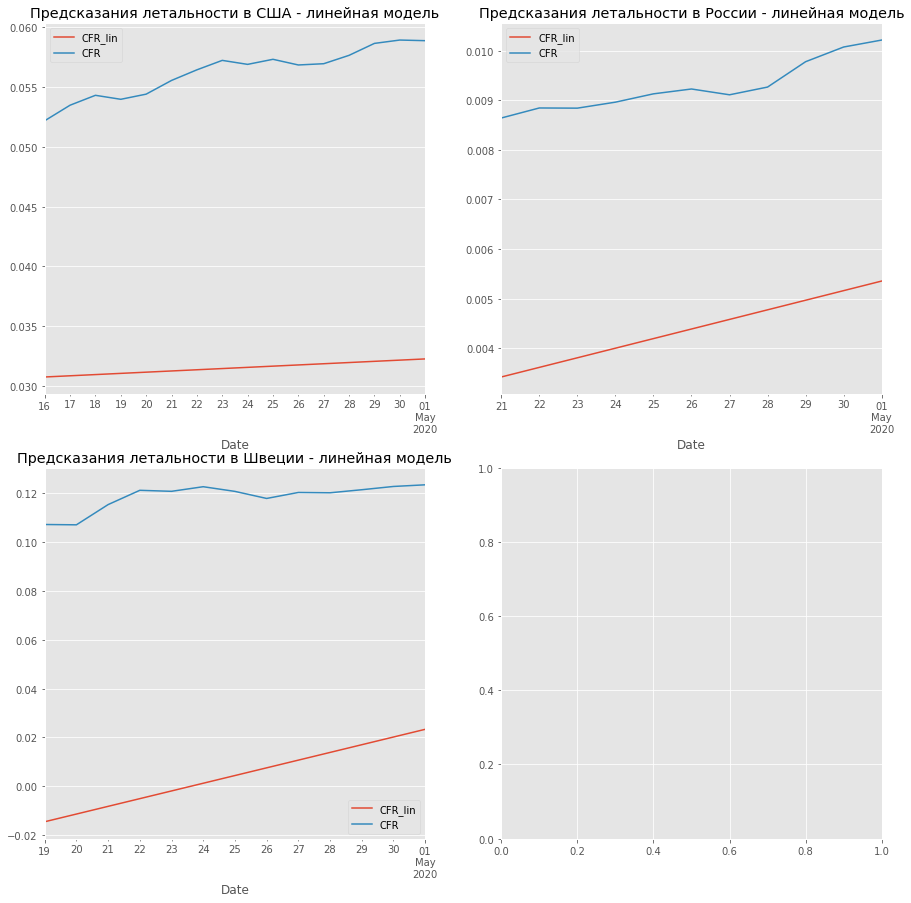

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

us_test_set.plot(kind = "line", x = 'Date',  y = ['CFR_lin',	'CFR'],  title = 'Предсказания летальности в США - линейная модель', ax=axes[0,0])
rus_test_set.plot(kind = "line", x = 'Date', y = ['CFR_lin',	'CFR'], title = 'Предсказания летальности в России - линейная модель', ax=axes[0,1])
sw_test_set.plot(kind = "line", x = 'Date', y = ['CFR_lin',	'CFR'], title = 'Предсказания летальности в Швеции - линейная модель', ax=axes[1,0])




In [ ]:
df_Results.loc[1,"Model"] = "Linear"
df_Results.loc[1,"Forecast_US"] = "Linear"
df_Results.loc[1,"RMSE_US"] = RMSE_linear_us
df_Results.loc[1,"Forecast_Russia"] = "Linear"
df_Results.loc[1,"RMSE_Russia"] = RMSE_linear_rus
df_Results.loc[1,"Forecast_Sweden"] = "Linear"
df_Results.loc[1,"RMSE_Sweden"] = RMSE_linear_sw
df_Results.head()

,Model,Forecast_US,RMSE_US,Forecast_Russia,RMSE_Russia,Forecast_Sweden,RMSE_Sweden
0,Mean,0.0331,0.0232,0.0065,0.0028,0.0454,0.0732
1,Linear,Linear,0.0247,Linear,0.0049,Linear,0.1143


### 2.3 Экспоненциальное сглаживание (Exponential smoothing)


Попробуйте так же применить Double exponential smoothing или Triple exponential smoothing.

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing

us_train_set_series = pd.Series(us_train_set['CFR'], us_train_set.index)
rus_train_set_series = pd.Series(rus_train_set['CFR'], rus_train_set.index) 
sw_train_set_series = pd.Series(sw_train_set['CFR'], sw_train_set.index) 

fit_us = ExponentialSmoothing(us_train_set_series).fit()
pr_sm_us = fit_us.predict(start=len(us_train_set['CFR']), end=len(us_train_set['CFR']) + len(us_test_set['CFR'])-1)

fit_rus = ExponentialSmoothing(rus_train_set_series).fit()
pr_sm_rus = fit_rus.predict(start=len(rus_train_set['CFR']), end=len(rus_train_set['CFR']) + len(rus_test_set['CFR'])-1)

fit_sw = ExponentialSmoothing(sw_train_set_series).fit()
pr_sm_sw = fit_sw.predict(start=len(sw_train_set['CFR']), end=len(sw_train_set['CFR']) + len(sw_test_set['CFR'])-1)

In [ ]:
us_test_set['CFR_exp'] = pr_sm_us.values
rus_test_set['CFR_exp'] = pr_sm_rus.values
sw_test_set['CFR_exp'] = pr_sm_sw.values

RMSE_ExpSmooth_us = RMSE(pr_sm_us.values, us_test_set['CFR'])
RMSE_ExpSmooth_rus = RMSE(pr_sm_rus.values, rus_test_set['CFR'])
RMSE_ExpSmooth_sw = RMSE(pr_sm_sw.values, sw_test_set['CFR'])

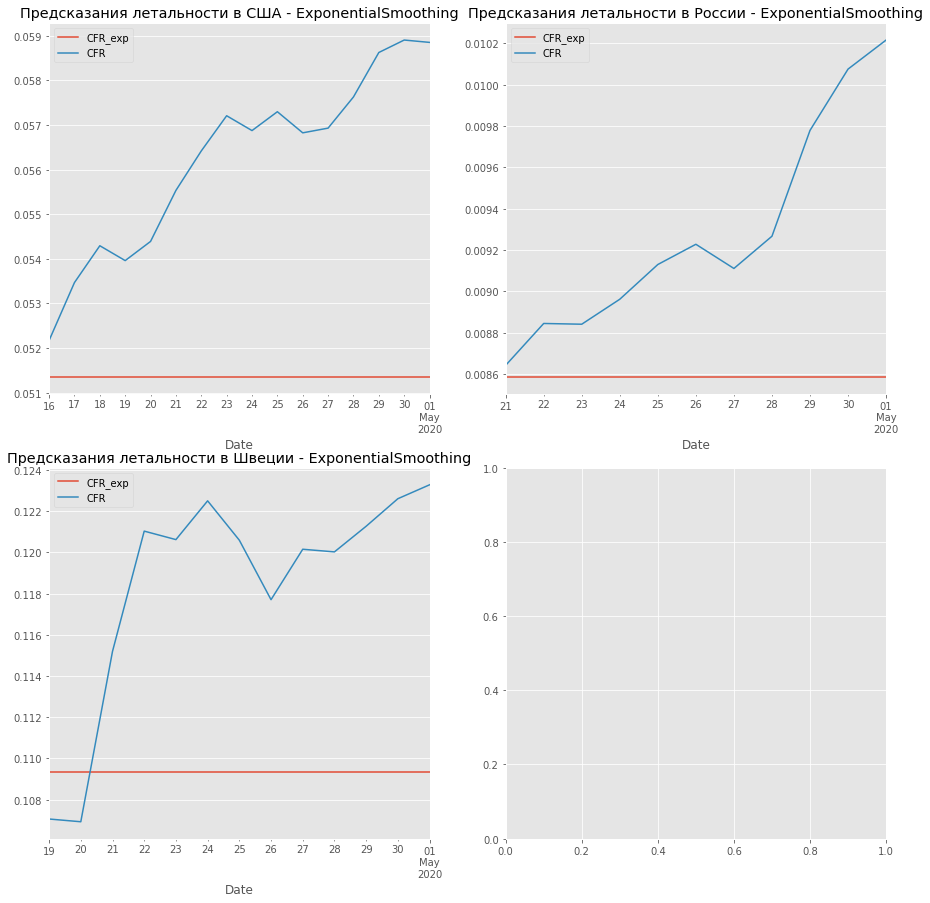

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

us_test_set.plot(kind = "line", x = 'Date',  y = ['CFR_exp',	'CFR'],  title = 'Предсказания летальности в США - ExponentialSmoothing', ax=axes[0,0])
rus_test_set.plot(kind = "line", x = 'Date', y = ['CFR_exp',	'CFR'], title = 'Предсказания летальности в России - ExponentialSmoothing', ax=axes[0,1])
sw_test_set.plot(kind = "line", x = 'Date', y = ['CFR_exp',	'CFR'], title = 'Предсказания летальности в Швеции - ExponentialSmoothing', ax=axes[1,0])



In [ ]:
df_Results.loc[2,"Model"] = "Exponential smoothing"
df_Results.loc[2,"Forecast_US"] = "Exponential smoothing"
df_Results.loc[2,"RMSE_US"] = RMSE_ExpSmooth_us
df_Results.loc[2,"Forecast_Russia"] = "Exponential smoothing"
df_Results.loc[2,"RMSE_Russia"] = RMSE_ExpSmooth_rus
df_Results.loc[2,"Forecast_Sweden"] = "Exponential smoothing"
df_Results.loc[2,"RMSE_Sweden"] = RMSE_ExpSmooth_sw

df_Results.sort_index(inplace=True)
df_Results

,Model,Forecast_US,RMSE_US,Forecast_Russia,RMSE_Russia,Forecast_Sweden,RMSE_Sweden
0,Mean,0.0331,0.0232,0.0065,0.0028,0.0454,0.0732
1,Linear,Linear,0.0247,Linear,0.0049,Linear,0.1143
2,Exponential smoothing,Exponential smoothing,0.0052,Exponential smoothing,0.0009,Exponential smoothing,0.0105
3,AR,AR,0.0567,AR,0.0093,AR,0.1184
4,MA,MA,0.0563,MA,0.0093,MA,0.1183


In [ ]:
df_Results

,Model,Forecast_US,RMSE_US,Forecast_Russia,RMSE_Russia,Forecast_Sweden,RMSE_Sweden
0,Mean,0.0331,0.0232,0.0065,0.0028,0.0454,0.0732
1,Linear,Linear,0.0247,Linear,0.0049,Linear,0.1143
8,Linear_reg,Linear (Confirmed),0.0209,Linear (Confirmed),0.0052,Linear (Confirmed),0.1112
9,Linear_reg,Linear (Recovered),0.0209,Linear (Recovered),0.0052,Linear (Recovered),0.1118
10,Linear_reg,Linear (Deaths),0.0207,Linear (Deaths),0.0052,Linear (Deaths),0.1114
11,Linear_reg,Linear (Deaths/Recovered),0.0207,Linear (Deaths/Recovered),0.0052,Linear (Deaths/Recovered),0.1113
12,Linear_reg,Linear (Recovered/Confirmed),0.0207,Linear (Recovered/Confirmed),0.0052,Linear (Recovered/Confirmed),0.1118


### 2.4 Скользящее среднее (MA - Moving average)

In [ ]:
from statsmodels.tsa.arima_model import ARMA

us_train_set['CFR_season_diff'].dropna(inplace = True)
rus_train_set['CFR_season_diff'].dropna(inplace = True)
sw_train_set['CFR_season_diff'].dropna(inplace = True)

mod_us = ARMA(us_train_set['CFR_season_diff'], order=(0,1))
mod_rus = ARMA(rus_train_set['CFR_season_diff'], order=(0,1))
mod_sw = ARMA(sw_train_set['CFR_season_diff'], order=(0,1))

res_us = mod_us.fit()
res_rus = mod_rus.fit()
res_sw = mod_sw.fit()

pr_ma_us = res_us.predict(start=len(us_train_set['CFR_season_diff']), end=len(us_train_set['CFR_season_diff']) + len(us_test_set['CFR_season_diff']) - 1)
pr_ma_rus = res_rus.predict(start=len(rus_train_set['CFR_season_diff']), end=len(rus_train_set['CFR_season_diff']) + len(rus_test_set['CFR_season_diff'])-1)
pr_ma_sw = res_sw.predict(start=len(sw_train_set['CFR_season_diff']), end=len(sw_train_set['CFR_season_diff']) + len(sw_test_set['CFR_season_diff'])-1)

us_test_set['CFR_ma'] = pr_ma_us
rus_test_set['CFR_ma'] = pr_ma_rus
sw_test_set['CFR_ma'] = pr_ma_sw

RMSE_ma_us = RMSE(pr_ma_us.values, us_test_set['CFR_season_diff'])
RMSE_ma_rus = RMSE(pr_ma_rus.values, rus_test_set['CFR_season_diff'])
RMSE_ma_sw = RMSE(pr_ma_sw.values, sw_test_set['CFR_season_diff'])

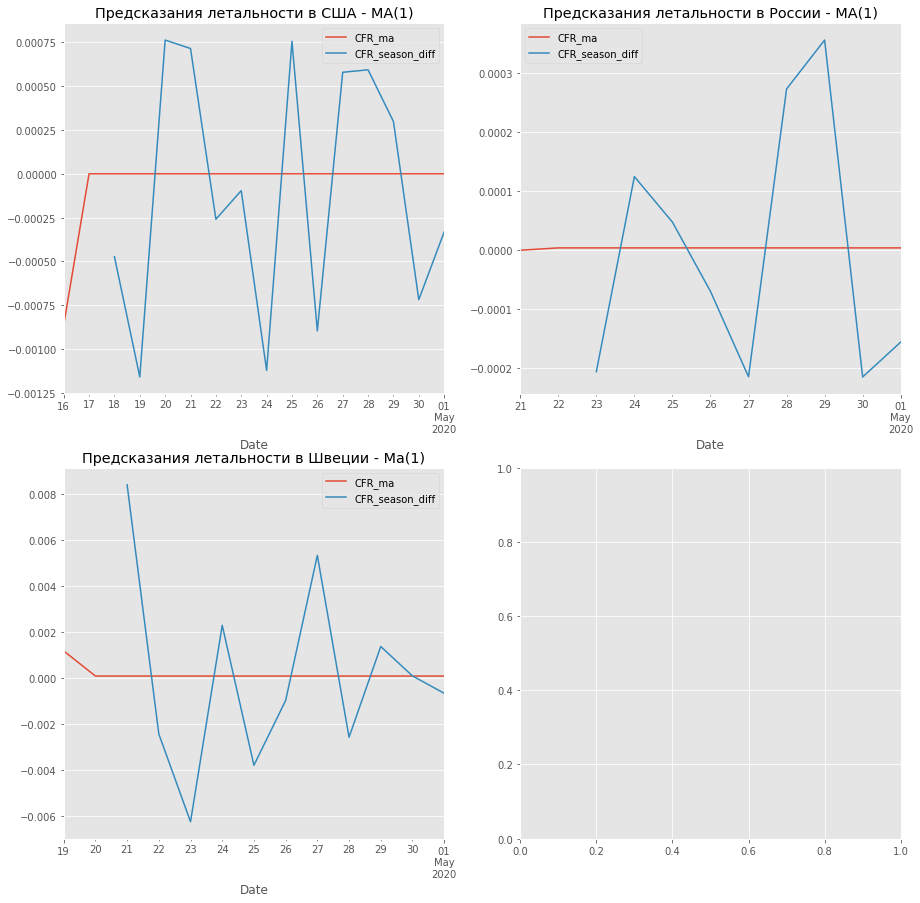

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

us_test_set.plot(kind = "line", x = 'Date',  y = ['CFR_ma',	'CFR_season_diff'],  title = 'Предсказания летальности в США - MA(1)', ax=axes[0,0])
rus_test_set.plot(kind = "line", x = 'Date', y = ['CFR_ma',	'CFR_season_diff'], title = 'Предсказания летальности в России - MA(1)', ax=axes[0,1])
sw_test_set.plot(kind = "line", x = 'Date', y = ['CFR_ma',	'CFR_season_diff'], title = 'Предсказания летальности в Швеции - Ma(1)', ax=axes[1,0])


In [ ]:
df_Results.loc[4,"Model"] = "MA"
df_Results.loc[4,"Forecast_US"] = "MA"
df_Results.loc[4,"RMSE_US"] = RMSE_ma_us
df_Results.loc[4,"Forecast_Russia"] = "MA"
df_Results.loc[4,"RMSE_Russia"] = RMSE_ma_rus
df_Results.loc[4,"Forecast_Sweden"] = "MA"
df_Results.loc[4,"RMSE_Sweden"] = RMSE_ma_sw
df_Results

,Model,Forecast_US,RMSE_US,Forecast_Russia,RMSE_Russia,Forecast_Sweden,RMSE_Sweden
0,Mean,0.0331,0.0232,0.0065,0.0028,0.0454,0.0732
1,Linear,Linear,0.0247,Linear,0.0049,Linear,0.1143
2,Exponential smoothing,Exponential smoothing,0.0052,Exponential smoothing,0.0009,Exponential smoothing,0.0105
3,AR,AR,0.0567,AR,0.0093,AR,0.1184
4,MA,MA,0.0007,MA,0.0002,MA,0.0040


### 2.5 Авторегрессионная модель (AR - Autoregressive model)

In [ ]:
from statsmodels.tsa.arima_model import ARMA

us_train_set['CFR_season_diff'].dropna(inplace = True)
rus_train_set['CFR_season_diff'].dropna(inplace = True)
sw_train_set['CFR_season_diff'].dropna(inplace = True)

mod_us = ARMA(us_train_set['CFR_season_diff'], order=(1,0))
mod_rus = ARMA(rus_train_set['CFR_season_diff'], order=(1,0))
mod_sw = ARMA(sw_train_set['CFR_season_diff'], order=(1,0))

res_us = mod_us.fit()
res_rus = mod_rus.fit()
res_sw = mod_sw.fit()

pr_ar_us = res_us.predict(start=len(us_train_set['CFR_season_diff']), end=len(us_train_set['CFR_season_diff']) + len(us_test_set['CFR_season_diff']) - 1)
pr_ar_rus = res_rus.predict(start=len(rus_train_set['CFR_season_diff']), end=len(rus_train_set['CFR_season_diff']) + len(rus_test_set['CFR_season_diff'])-1)
pr_ar_sw = res_sw.predict(start=len(sw_train_set['CFR_season_diff']), end=len(sw_train_set['CFR_season_diff']) + len(sw_test_set['CFR_season_diff'])-1)

us_test_set['CFR_ar'] = pr_ar_us
rus_test_set['CFR_ar'] = pr_ar_rus
sw_test_set['CFR_ar'] = pr_ar_sw

RMSE_ar_us = RMSE(pr_ar_us.values, us_test_set['CFR_season_diff'])
RMSE_ar_rus = RMSE(pr_ar_rus.values, rus_test_set['CFR_season_diff'])
RMSE_ar_sw = RMSE(pr_ar_sw.values, sw_test_set['CFR_season_diff'])


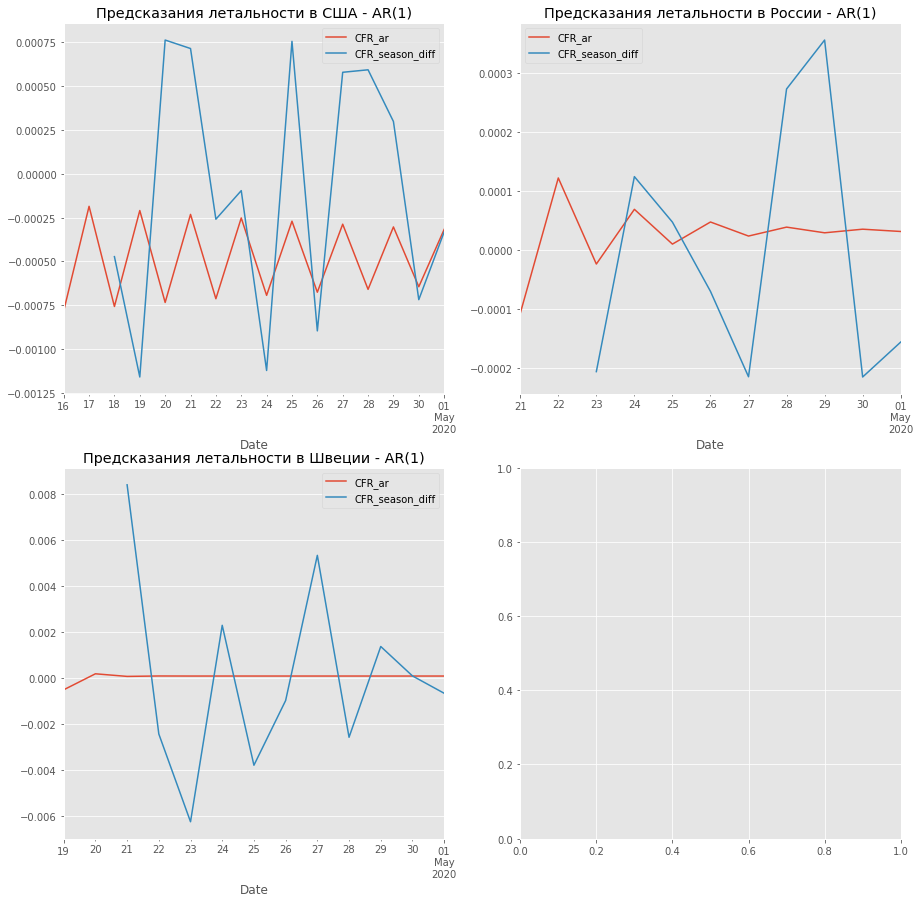

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

us_test_set.plot(kind = "line", x = 'Date',  y = ['CFR_ar',	'CFR_season_diff'],  title = 'Предсказания летальности в США - AR(1)', ax=axes[0,0])
rus_test_set.plot(kind = "line", x = 'Date', y = ['CFR_ar',	'CFR_season_diff'], title = 'Предсказания летальности в России - AR(1)', ax=axes[0,1])
sw_test_set.plot(kind = "line", x = 'Date', y = ['CFR_ar',	'CFR_season_diff'], title = 'Предсказания летальности в Швеции - AR(1)', ax=axes[1,0])


In [ ]:
df_Results.loc[3,"Model"] = "AR"
df_Results.loc[3,"Forecast_US"] = "AR"
df_Results.loc[3,"RMSE_US"] = RMSE_ar_us
df_Results.loc[3,"Forecast_Russia"] = "AR"
df_Results.loc[3,"RMSE_Russia"] = RMSE_ar_rus
df_Results.loc[3,"Forecast_Sweden"] = "AR"
df_Results.loc[3,"RMSE_Sweden"] = RMSE_ar_sw
df_Results

,Model,Forecast_US,RMSE_US,Forecast_Russia,RMSE_Russia,Forecast_Sweden,RMSE_Sweden
0,Mean,0.0331,0.0232,0.0065,0.0028,0.0454,0.0732
1,Linear,Linear,0.0247,Linear,0.0049,Linear,0.1143
2,Exponential smoothing,Exponential smoothing,0.0052,Exponential smoothing,0.0009,Exponential smoothing,0.0105
3,AR,AR,0.0008,AR,0.0002,AR,0.0040
4,MA,MA,0.0007,MA,0.0002,MA,0.0040


Поэксперементируйте с гиперпараметрами модели.

In [ ]:
# Ваш код здесь

### 2.6 ARMA

Поэксперементируйте с гиперпараметрами модели.

In [ ]:
from statsmodels.tsa.arima_model import ARMA

us_train_set['CFR_season_diff'].dropna(inplace = True)
rus_train_set['CFR_season_diff'].dropna(inplace = True)
sw_train_set['CFR_season_diff'].dropna(inplace = True)

mod_us = ARMA(us_train_set['CFR_season_diff'], order=(1,1))
mod_rus = ARMA(rus_train_set['CFR_season_diff'], order=(1,1))
mod_sw = ARMA(sw_train_set['CFR_season_diff'], order=(3,3))

res_us = mod_us.fit()
res_rus = mod_rus.fit()
res_sw = mod_sw.fit()

pr_arma_us = res_us.predict(start=len(us_train_set['CFR_season_diff']), end=len(us_train_set['CFR_season_diff']) + len(us_test_set['CFR_season_diff']) - 1)
pr_arma_rus = res_rus.predict(start=len(rus_train_set['CFR_season_diff']), end=len(rus_train_set['CFR_season_diff']) + len(rus_test_set['CFR_season_diff'])-1)
pr_arma_sw = res_sw.predict(start=len(sw_train_set['CFR_season_diff']), end=len(sw_train_set['CFR_season_diff']) + len(sw_test_set['CFR_season_diff'])-1)

us_test_set['CFR_arma'] = pr_arma_us
rus_test_set['CFR_arma'] = pr_arma_rus
sw_test_set['CFR_arma'] = pr_arma_sw

RMSE_arma_us = RMSE(pr_arma_us.values, us_test_set['CFR_season_diff'])
RMSE_arma_rus = RMSE(pr_arma_rus.values, rus_test_set['CFR_season_diff'])
RMSE_arma_sw = RMSE(pr_arma_sw.values, sw_test_set['CFR_season_diff'])

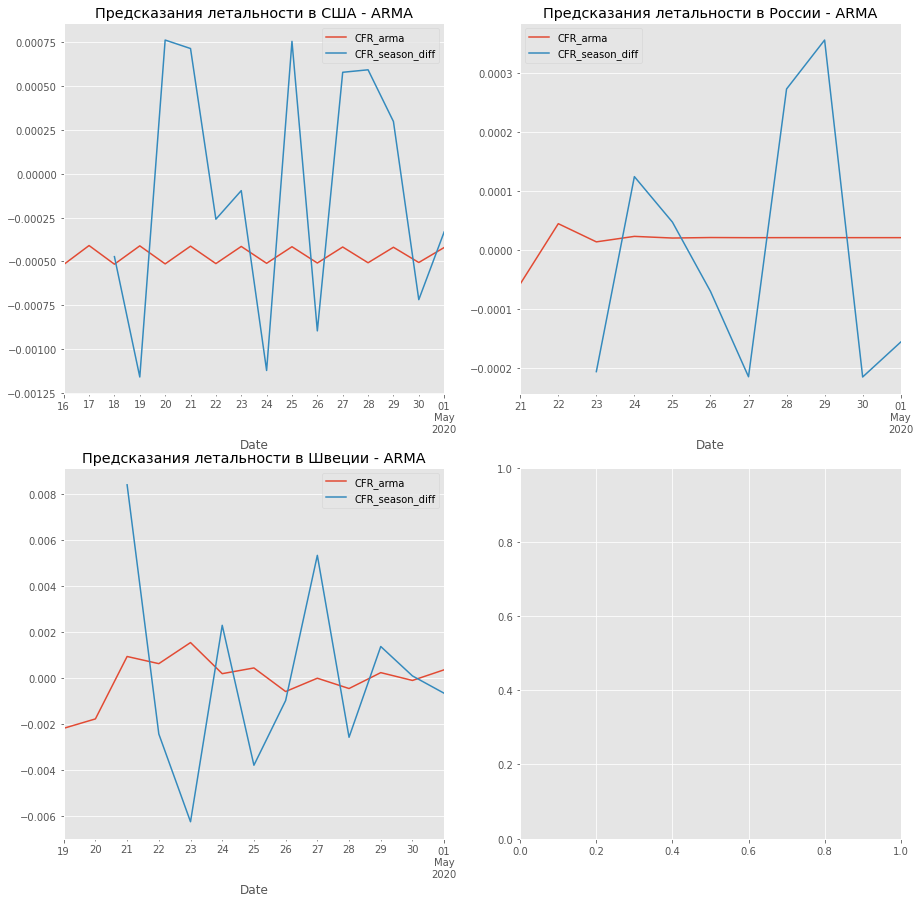

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

us_test_set.plot(kind = "line", x = 'Date',  y = ['CFR_arma',	'CFR_season_diff'],  title = 'Предсказания летальности в США - ARMA', ax=axes[0,0])
rus_test_set.plot(kind = "line", x = 'Date', y = ['CFR_arma',	'CFR_season_diff'], title = 'Предсказания летальности в России - ARMA', ax=axes[0,1])
sw_test_set.plot(kind = "line", x = 'Date', y = ['CFR_arma',	'CFR_season_diff'], title = 'Предсказания летальности в Швеции - ARMA', ax=axes[1,0])

In [ ]:
df_Results.loc[5,"Model"] = "ARMA"
df_Results.loc[5,"Forecast_US"] = "ARMA"
df_Results.loc[5,"RMSE_US"] = RMSE_arma_us
df_Results.loc[5,"Forecast_Russia"] = "ARMA"
df_Results.loc[5,"RMSE_Russia"] = RMSE_arma_rus
df_Results.loc[5,"Forecast_Sweden"] = "ARMA"
df_Results.loc[5,"RMSE_Sweden"] = RMSE_ar_sw
df_Results

,Model,Forecast_US,RMSE_US,Forecast_Russia,RMSE_Russia,Forecast_Sweden,RMSE_Sweden
0,Mean,0.0331,0.0232,0.0065,0.0028,0.0454,0.0732
1,Linear,Linear,0.0247,Linear,0.0049,Linear,0.1143
2,Exponential smoothing,Exponential smoothing,0.0052,Exponential smoothing,0.0009,Exponential smoothing,0.0105
3,AR,AR,0.0008,AR,0.0002,AR,0.0040
4,MA,MA,0.0007,MA,0.0002,MA,0.0040
11,Linear_reg,Linear (Deaths/Recovered),0.0207,Linear (Deaths/Recovered),0.0052,Linear (Deaths/Recovered),0.1113
5,ARMA,ARMA,0.0008,ARMA,0.0002,ARMA,0.0040


### 2.7 Линейная модель с регрессией (Linear Regression Model)

Какие признаки оказались наиболее значимыми?


Было проведено 5 расчетов предсказаний с использованием переменных: Confirmed, Recovered,	Deaths, затем Deaths/Recovered и Recovered/Confirmed. Разница в результатах оказалась незначительная, но наиболее значимой оказалась переменная Deaths/Recovered.


In [ ]:
us_train_set.tail()

,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths,CFR
Date,,,,,,,,,
2020-04-11,2020-04-11,US,NaN,37.0902,-95.7129,"526,396.0000","31,270.0000","24,342.0000",0.0462
2020-04-12,2020-04-12,US,NaN,37.0902,-95.7129,"555,313.0000","32,988.0000","26,086.0000",0.0470
2020-04-13,2020-04-13,US,NaN,37.0902,-95.7129,"580,619.0000","43,482.0000","27,870.0000",0.0480
2020-04-14,2020-04-14,US,NaN,37.0902,-95.7129,"607,670.0000","47,763.0000","30,262.0000",0.0498
2020-04-15,2020-04-15,US,NaN,37.0902,-95.7129,"636,350.0000","52,096.0000","32,734.0000",0.0514


In [ ]:
model_linear_us_reg = smf.ols('CFR ~ timeIndex + Deaths/Recovered', data = us_train_set).fit()
model_linear_rus_reg = smf.ols('CFR ~ timeIndex + Deaths/Recovered', data = rus_train_set).fit()
model_linear_sw_reg = smf.ols('CFR ~ timeIndex + Deaths/Recovered', data = sw_train_set).fit()

pr_reg_us = model_linear_us_reg.predict()
pr_reg_rus = model_linear_rus_reg.predict()
pr_reg_sw = model_linear_sw_reg.predict()

In [ ]:
pr_reg_us = pr_reg_us[:len(us_test_set['CFR'])]
RMSE_linear_reg_us = RMSE(pr_reg_us, us_test_set['CFR'])
us_test_set['CFR_lin_reg'] = pr_reg_us

pr_reg_rus = pr_reg_rus[:len(rus_test_set['CFR'])]
RMSE_linear_reg_rus = RMSE(pr_reg_rus, rus_test_set['CFR'])
rus_test_set['CFR_lin_reg'] = pr_reg_rus

pr_reg_sw = pr_reg_sw[:len(sw_test_set['CFR'])]
RMSE_linear_reg_sw = RMSE(pr_reg_sw, sw_test_set['CFR'])
sw_test_set['CFR_lin_reg'] = pr_reg_sw

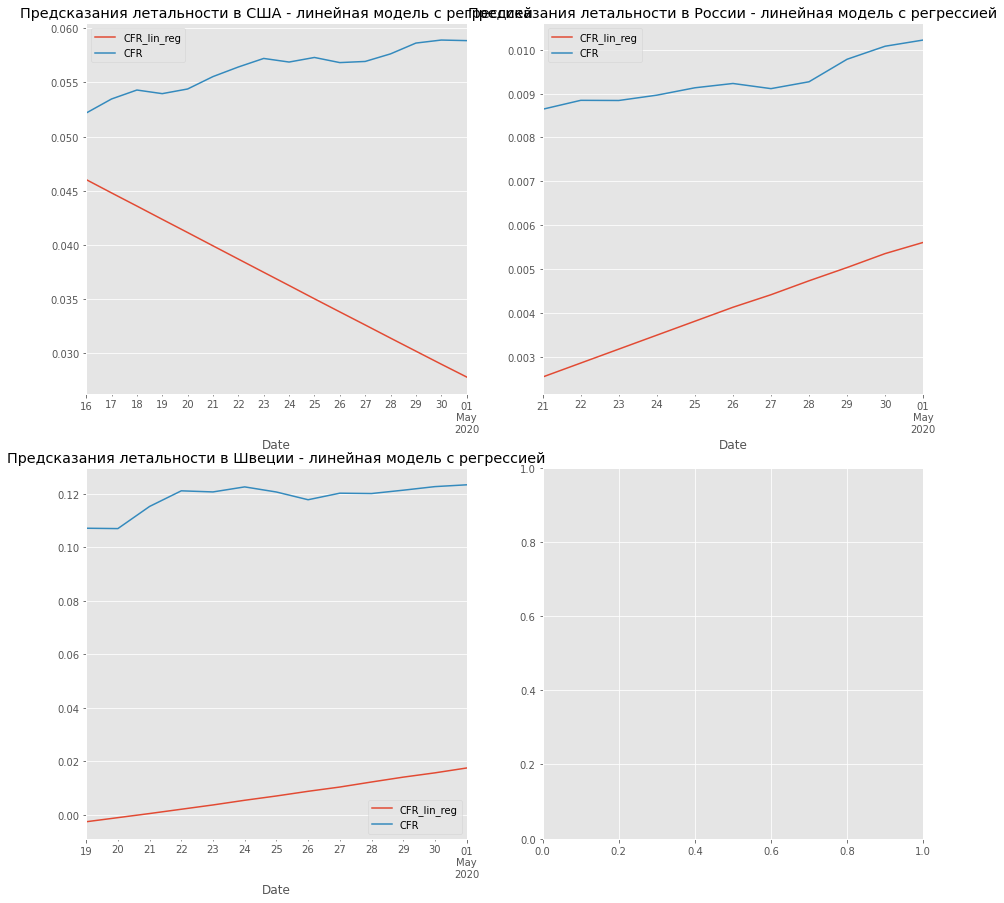

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

us_test_set.plot(kind = "line", x = 'Date',  y = ['CFR_lin_reg',	'CFR'],  title = 'Предсказания летальности в США - линейная модель с регрессией', ax=axes[0,0])
rus_test_set.plot(kind = "line", x = 'Date', y = ['CFR_lin_reg',	'CFR'], title = 'Предсказания летальности в России - линейная модель с регрессией', ax=axes[0,1])
sw_test_set.plot(kind = "line", x = 'Date', y = ['CFR_lin_reg',	'CFR'], title = 'Предсказания летальности в Швеции - линейная модель с регрессией', ax=axes[1,0])


In [ ]:
df_Results.loc[11,"Model"] = "Linear_reg"
df_Results.loc[11,"Forecast_US"] = "Linear (Deaths/Recovered)"
df_Results.loc[11,"RMSE_US"] = RMSE_linear_reg_us
df_Results.loc[11,"Forecast_Russia"] = "Linear (Deaths/Recovered)"
df_Results.loc[11,"RMSE_Russia"] = RMSE_linear_reg_rus
df_Results.loc[11,"Forecast_Sweden"] = "Linear (Deaths/Recovered)"
df_Results.loc[11,"RMSE_Sweden"] = RMSE_linear_reg_sw
df_Results

,Model,Forecast_US,RMSE_US,Forecast_Russia,RMSE_Russia,Forecast_Sweden,RMSE_Sweden
0,Mean,0.0331,0.0232,0.0065,0.0028,0.0454,0.0732
1,Linear,Linear,0.0247,Linear,0.0049,Linear,0.1143
2,Exponential smoothing,Exponential smoothing,0.0052,Exponential smoothing,0.0009,Exponential smoothing,0.0105
3,AR,AR,0.0008,AR,0.0002,AR,0.0040
4,MA,MA,0.0007,MA,0.0002,MA,0.0040
11,Linear_reg,Linear (Deaths/Recovered),0.0207,Linear (Deaths/Recovered),0.0052,Linear (Deaths/Recovered),0.1113


2.11 (Бонус) Используйте любую другую известную вам модель для предсказания.

![](https://lh3.googleusercontent.com/proxy/apcO3hDn7joDv-qU7Cz1gTc8zAvJpE3XmknjktN4OOyRnNwkcQf9nMfh26Be1McM9Hdd4PE3PP5ZIbUyvRb-q3wx-NE)

### 2.11 Выводы

1. Из представленных моделей лучше всего себя показала MA - по всем показателям.
2. Наибольшая ошибка приходится на расчет CFR Швеции, что может быть обусловленно наиболее высоким показателем летальности.

In [ ]:
df_Results

,Model,Forecast_US,RMSE_US,Forecast_Russia,RMSE_Russia,Forecast_Sweden,RMSE_Sweden
0,Mean,0.0331,0.0232,0.0065,0.0028,0.0454,0.0732
1,Linear,Linear,0.0247,Linear,0.0049,Linear,0.1143
2,Exponential smoothing,Exponential smoothing,0.0052,Exponential smoothing,0.0009,Exponential smoothing,0.0105
3,AR,AR,0.0008,AR,0.0002,AR,0.0040
4,MA,MA,0.0007,MA,0.0002,MA,0.0040
11,Linear_reg,Linear (Deaths/Recovered),0.0207,Linear (Deaths/Recovered),0.0052,Linear (Deaths/Recovered),0.1113
5,ARMA,ARMA,0.0008,ARMA,0.0002,ARMA,0.0040


## Выводы по работе
1. Короновирус зафиксирован в 187 стране мира, в большинстве случаев обнаружен и активно развивался с конца марта.
2. Есть схожие патерны в начале эпидемии, но все равно распространение болезни уникально для каждой страны.
3. Пока стабилизировать количество больных смогли только страны, где короновирус обнаружили зимой (Например, Китай).
4. Нет универсальной модели для построения предсказаний. Однако в этом случае лучше всего себя показала MA.